# Visualisierung der "raw counts" und der normalisierten "counts"

In [1]:
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Gemeinsame Einstellungen
folder_raw = "../data/raw_counts"
folder_filtered = "../data/filtered"
file_exts = (".csv", ".tsv")

def load_filtered_df(path, filename, require_entity=True):
    sep = "\t" if filename.endswith(".tsv") else ","
    df = pd.read_csv(os.path.join(path, filename), sep=sep)

    if require_entity:
        if "Entity" not in df.columns:
            print(f"'Entity'-Spalte fehlt in {filename}")
            return None
        df = df[df["Entity"].str.lower() == "phage"]
        if df.empty:
            print(f"Keine 'phage' Zeilen in {filename}")
            return None

    if "Geneid" not in df.columns:
        print(f"'Geneid'-Spalte fehlt in {filename}")
        return None

    expr_cols = [col for col in df.columns if re.match(r'^[\w\d\-\.]+_R\d+$', col)]
    if not expr_cols:
        print(f"Ungültige Daten in {filename}")
        return None

    return df.set_index("Geneid")[expr_cols]

def list_data_files(folder, exts=file_exts):
    return [f for f in os.listdir(folder) if f.endswith(exts)]

def plot_heatmap(df, title):
    plt.figure(figsize=(12, max(6, len(df) * 0.025)))
    sns.heatmap(df, cmap="viridis", cbar_kws={'label': 'Counts'})
    plt.title(title)
    plt.xlabel("Zeitpunkt_Replikat")
    plt.ylabel("Gene")
    plt.tight_layout()
    plt.show()


### Genexpression Linienplots:

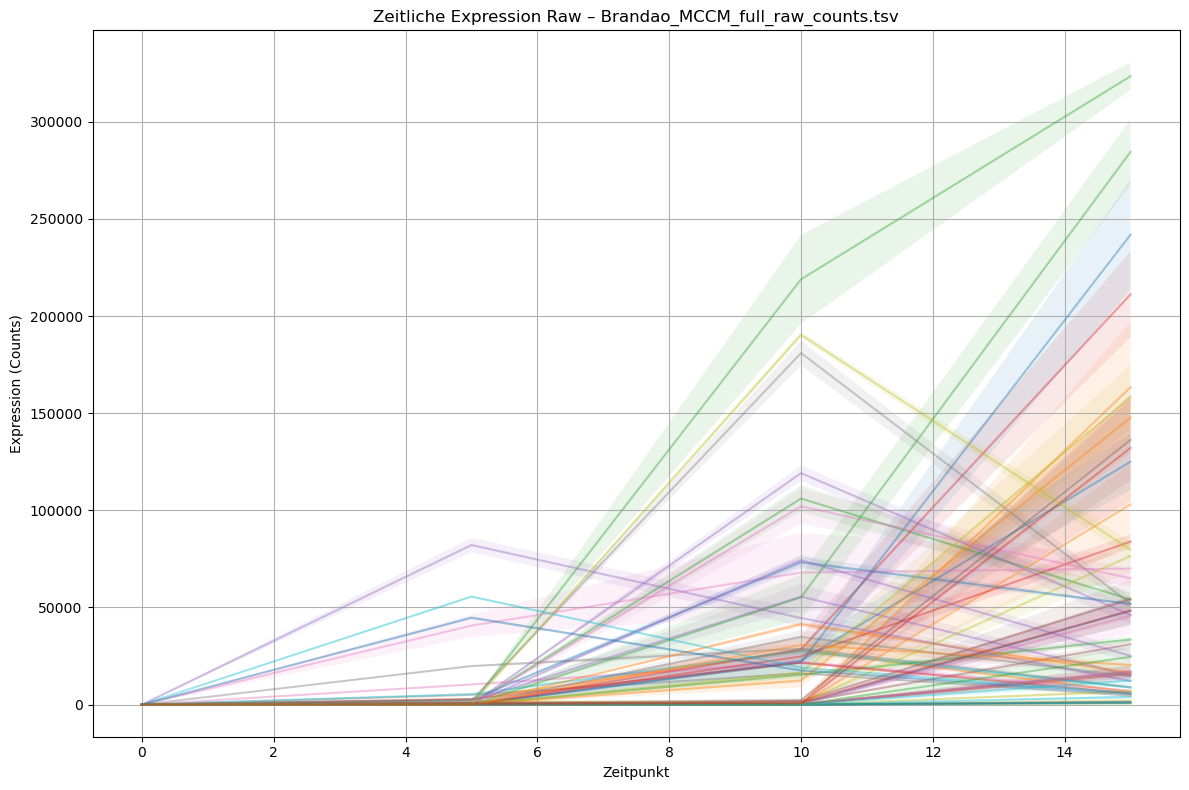

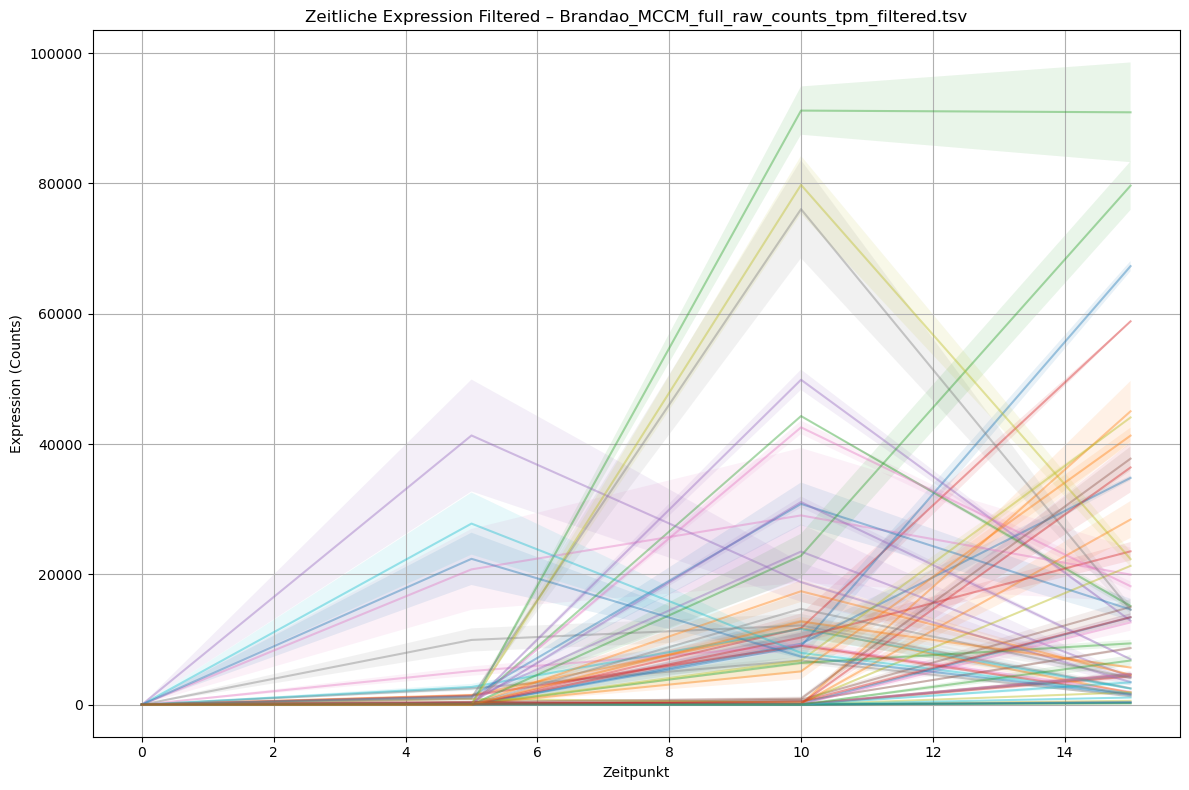

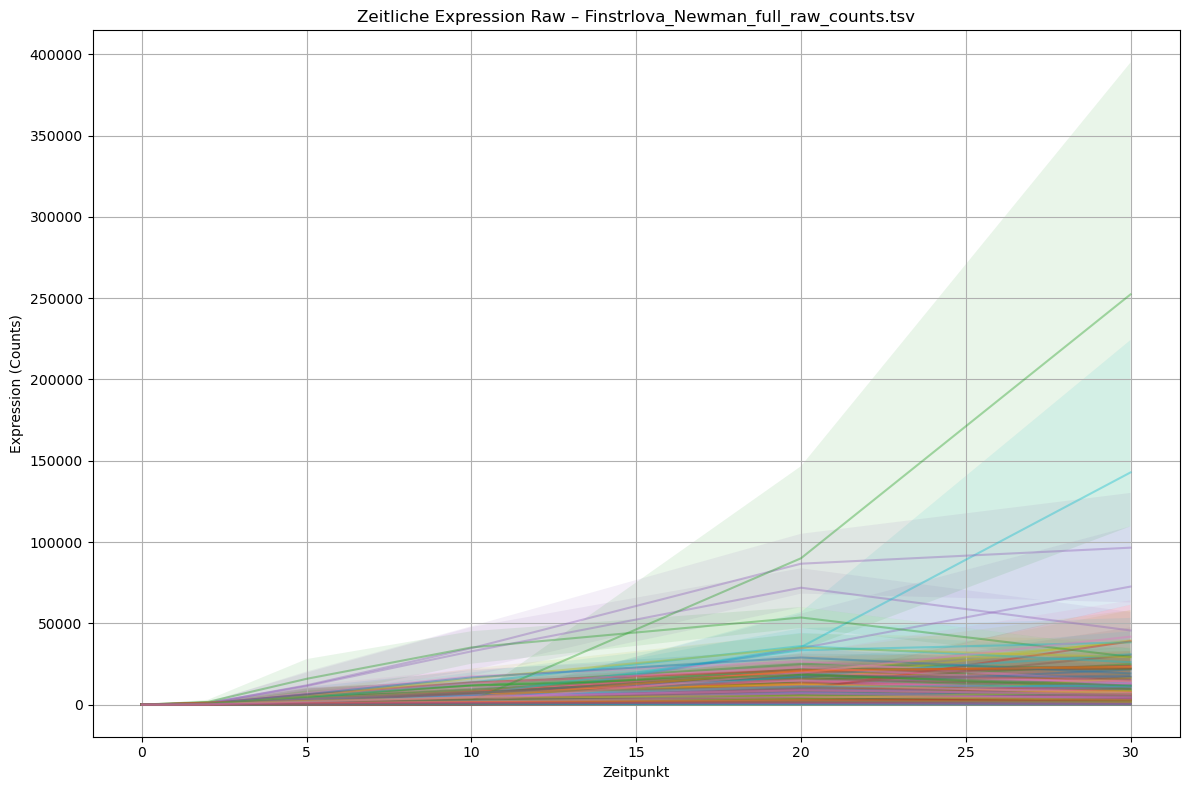

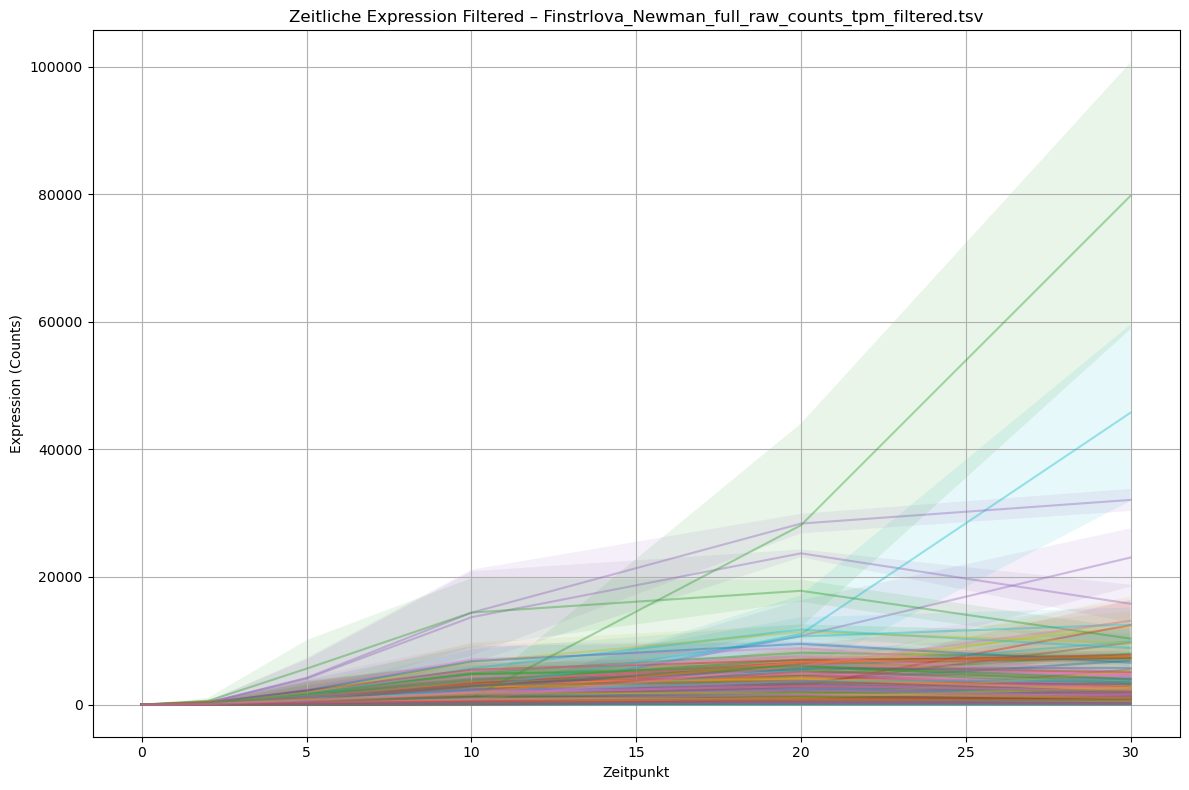

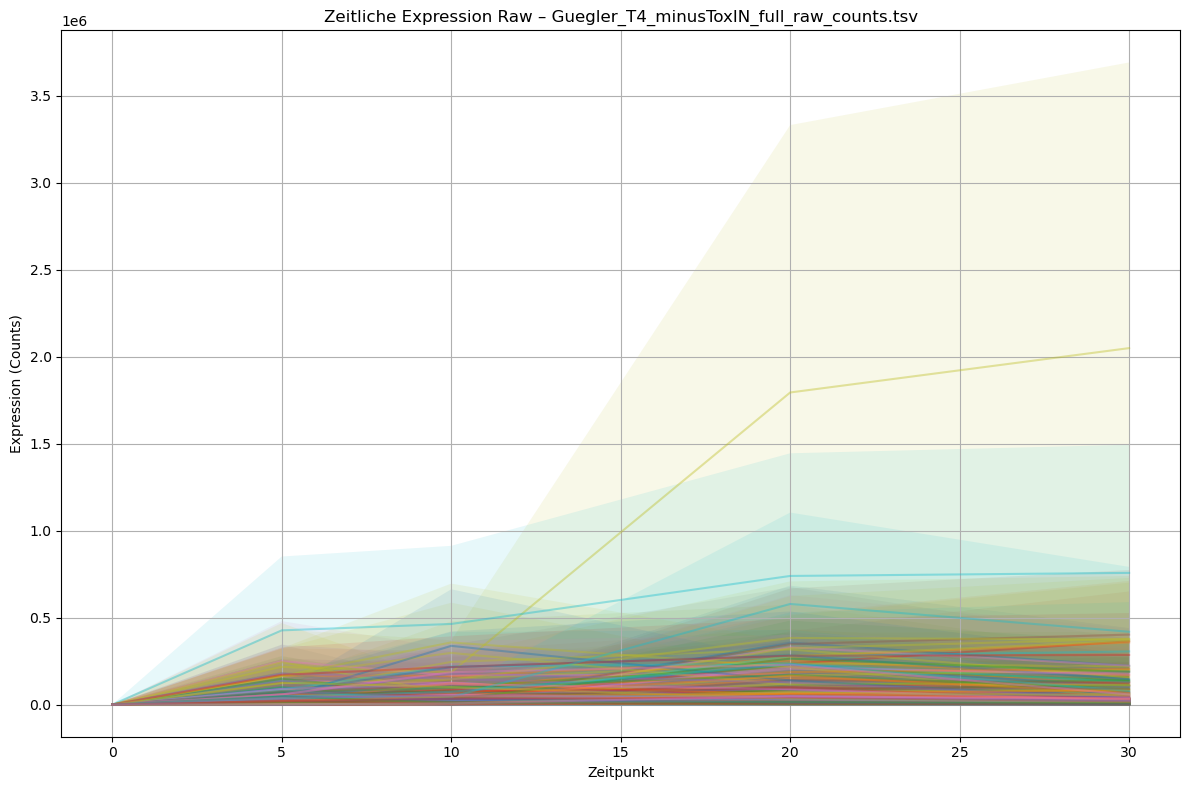

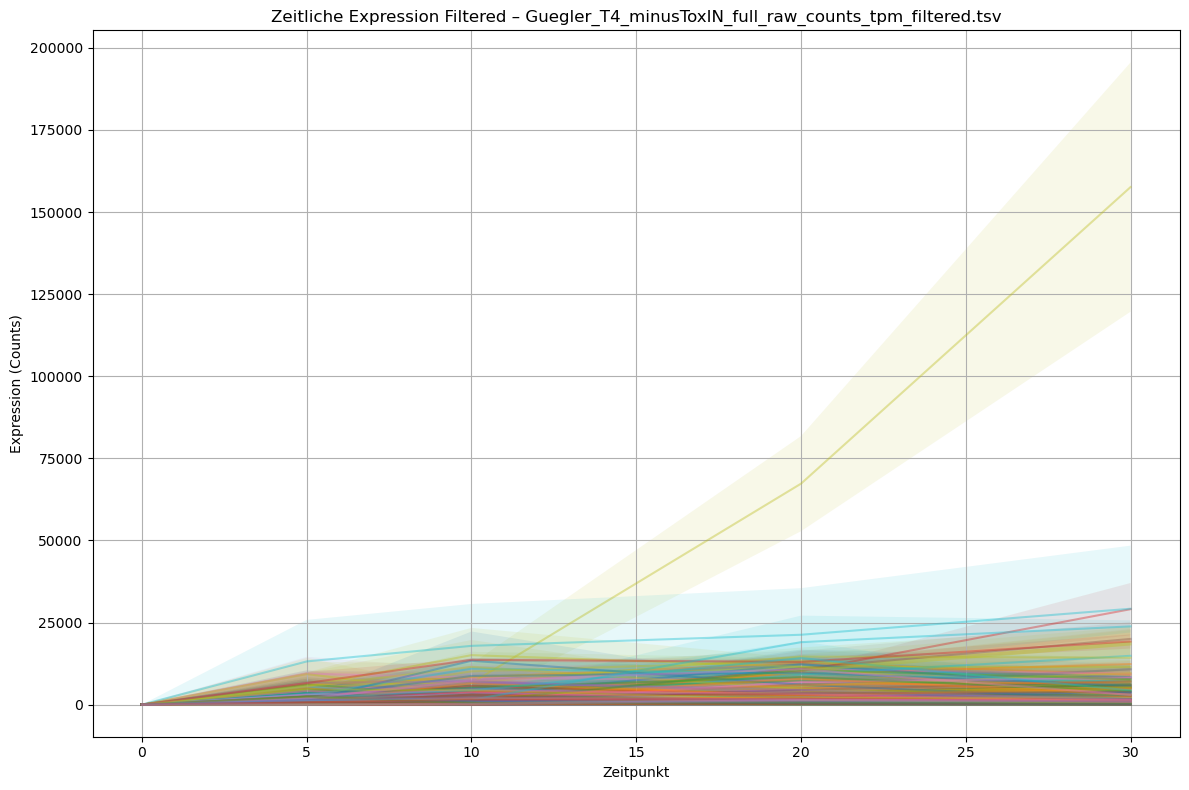

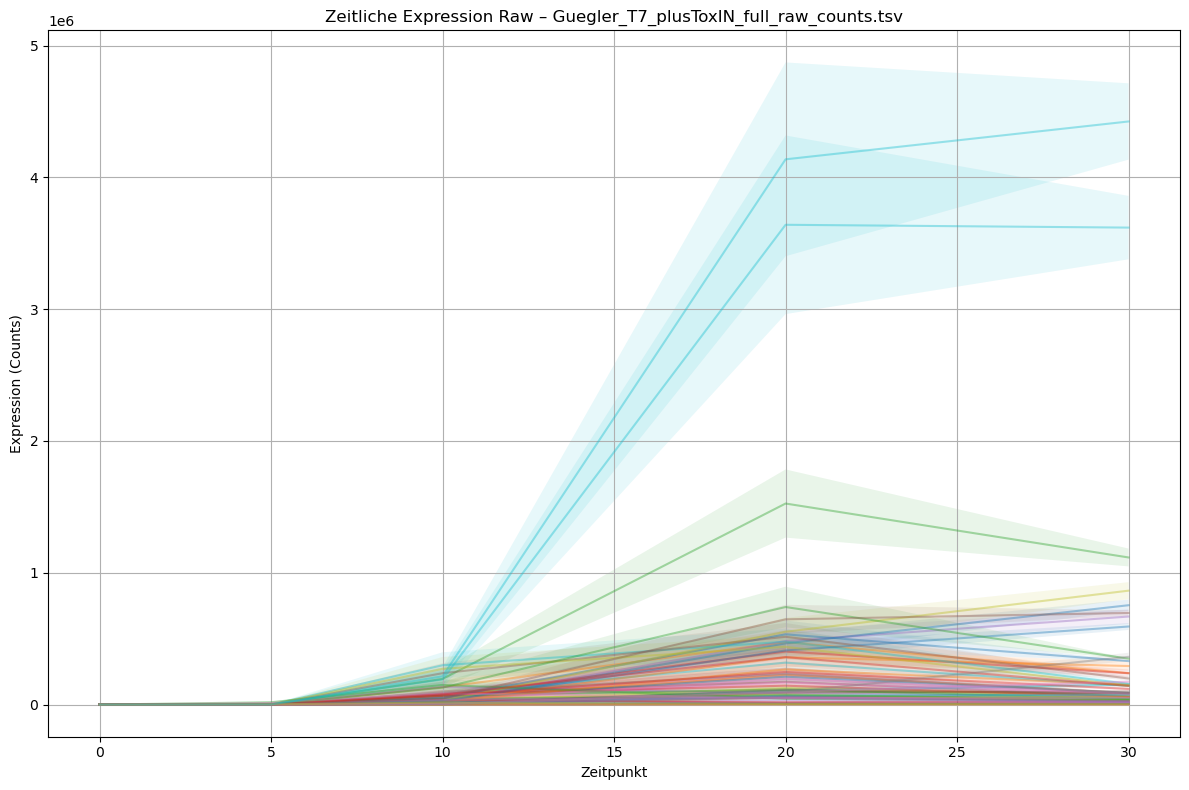

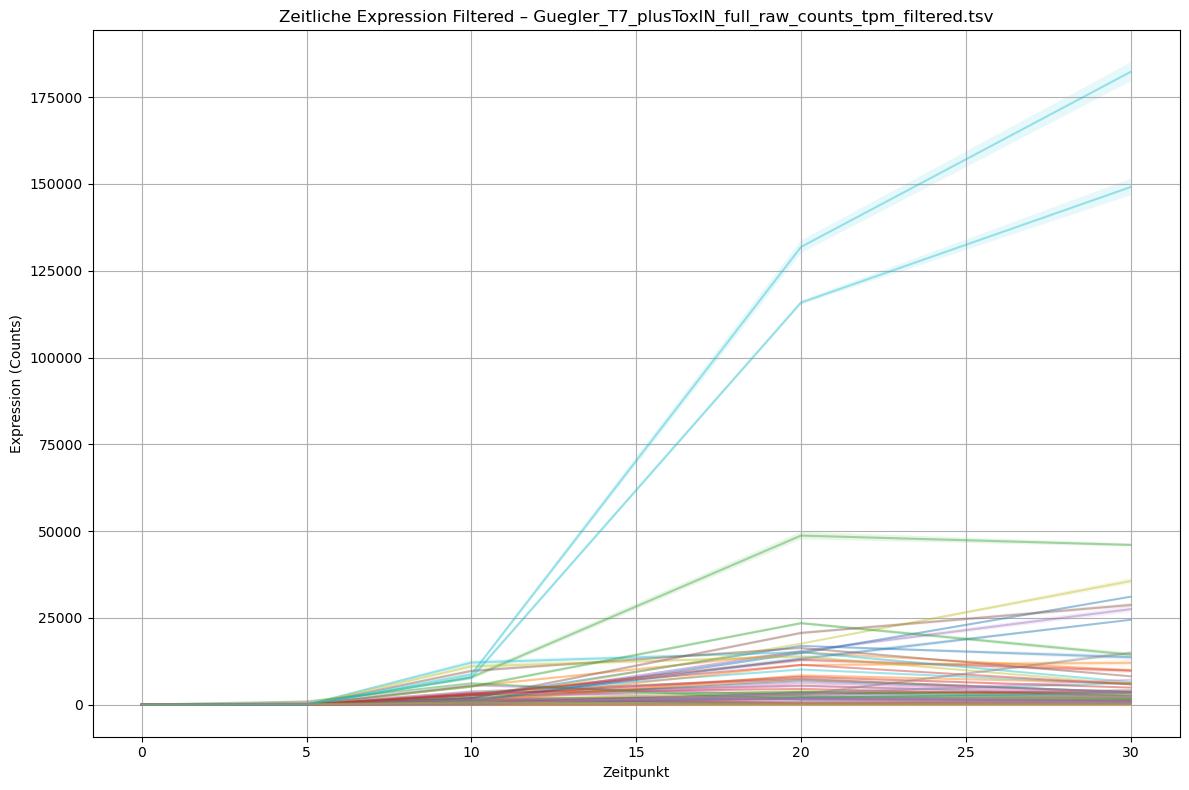

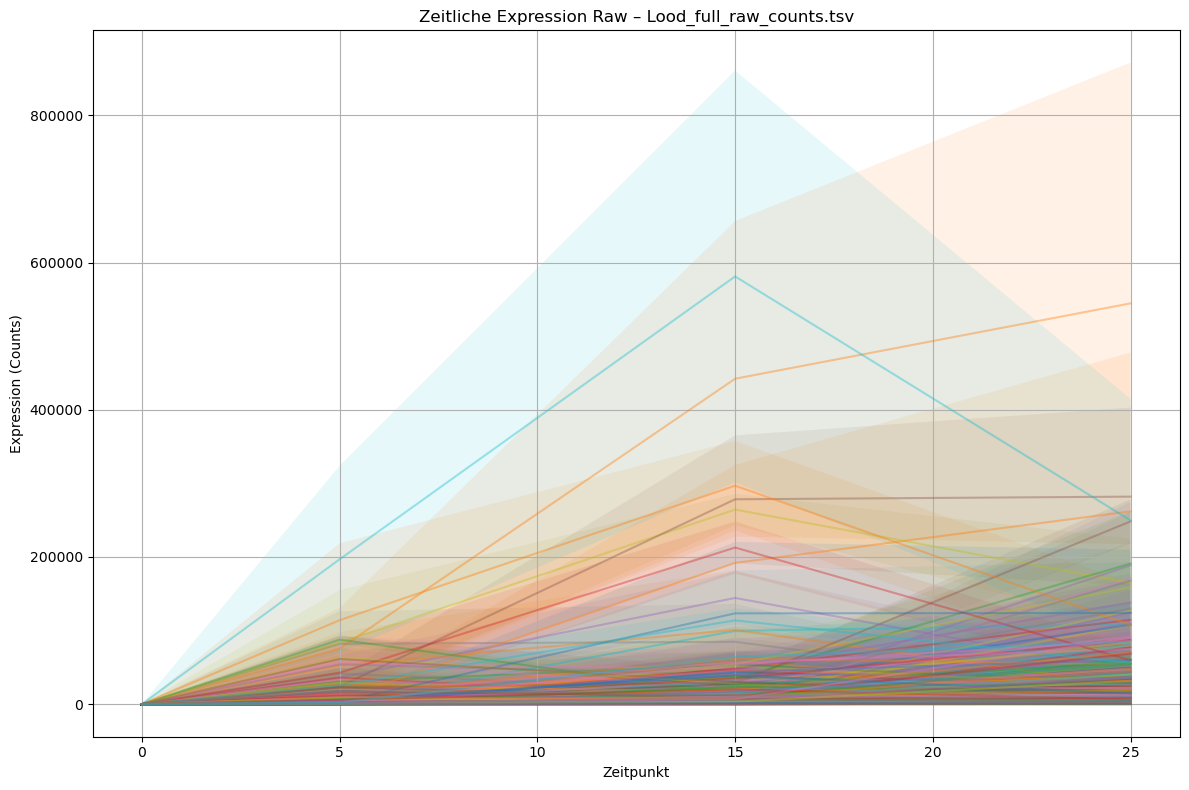

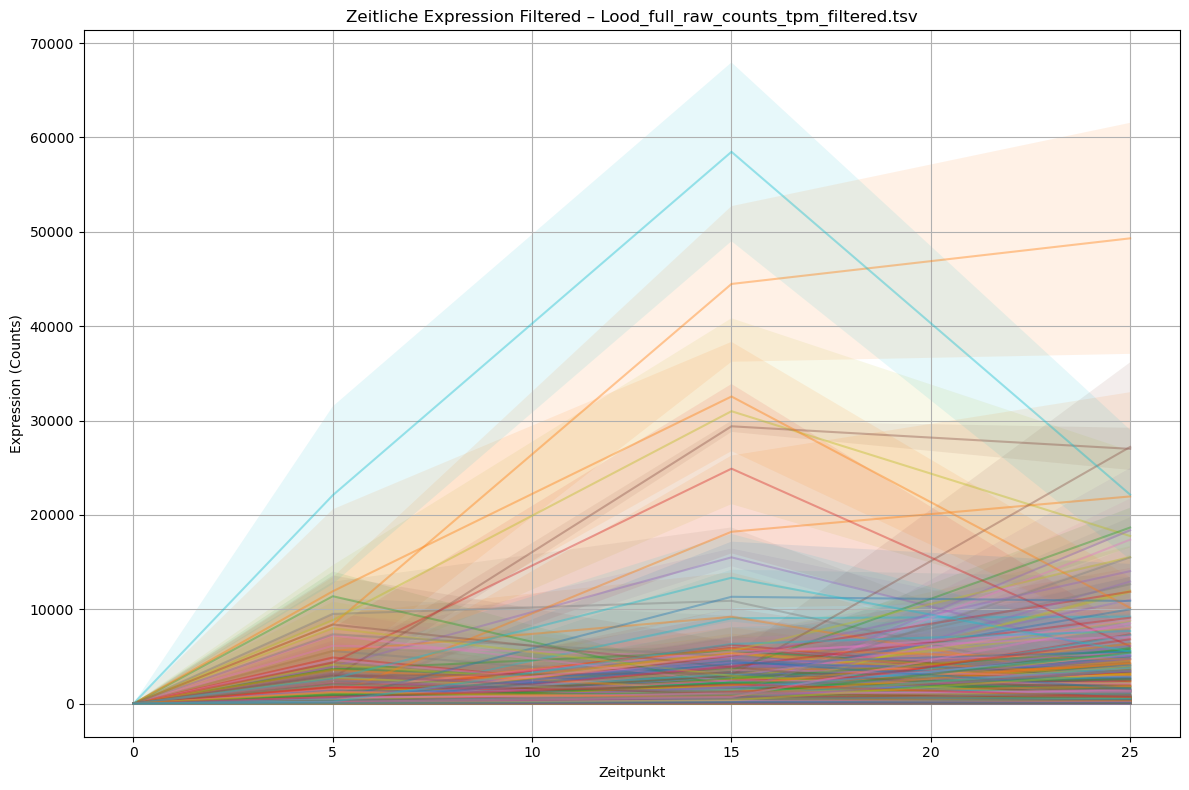

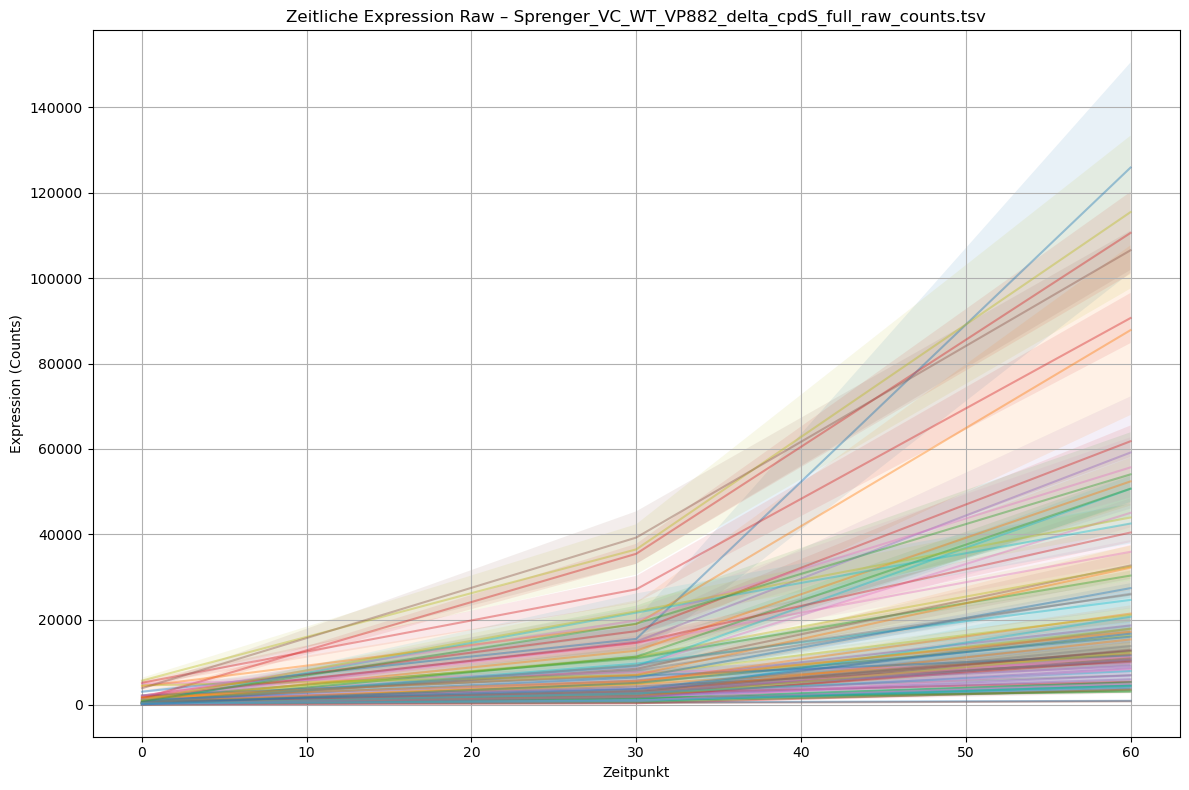

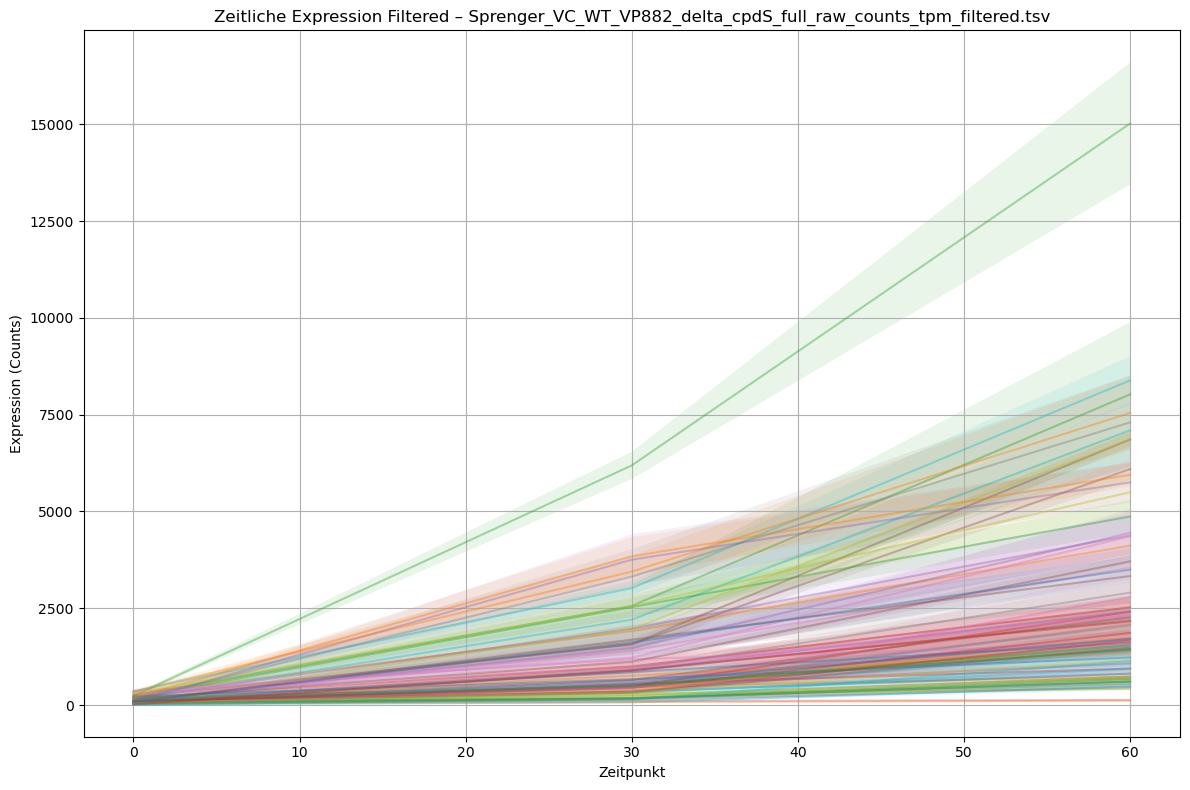

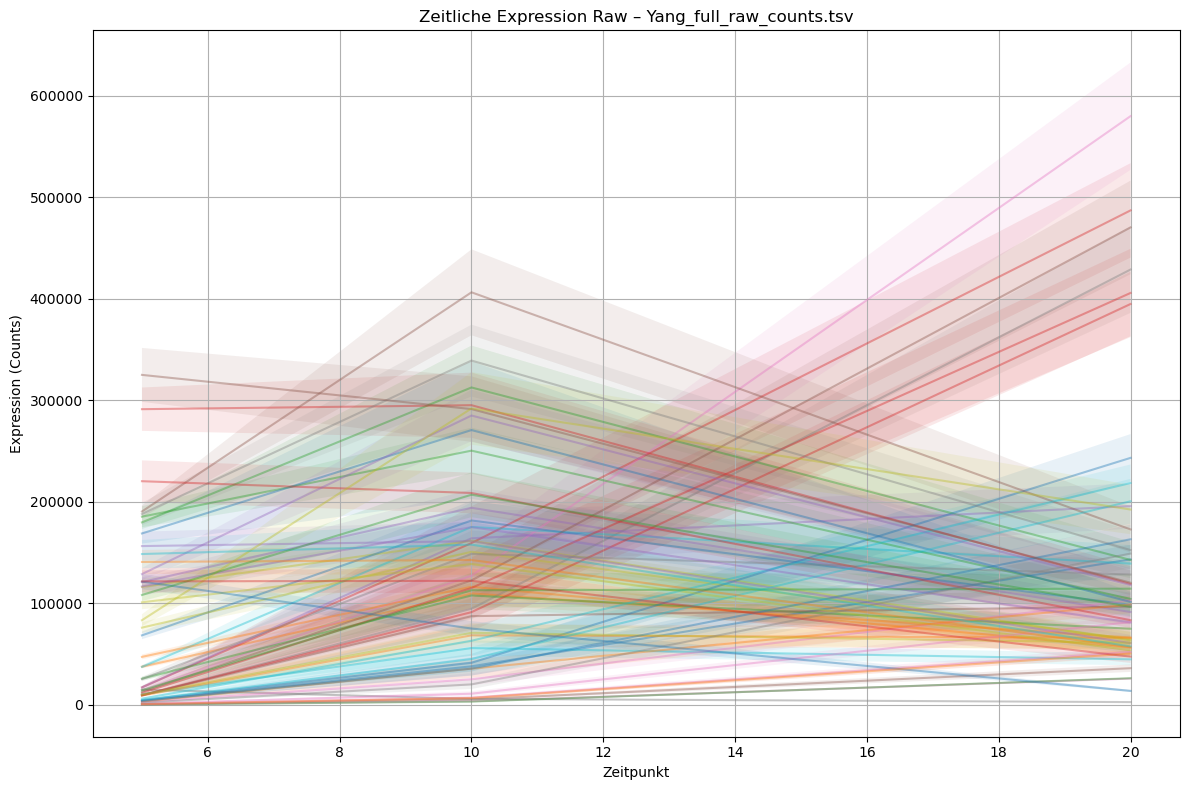

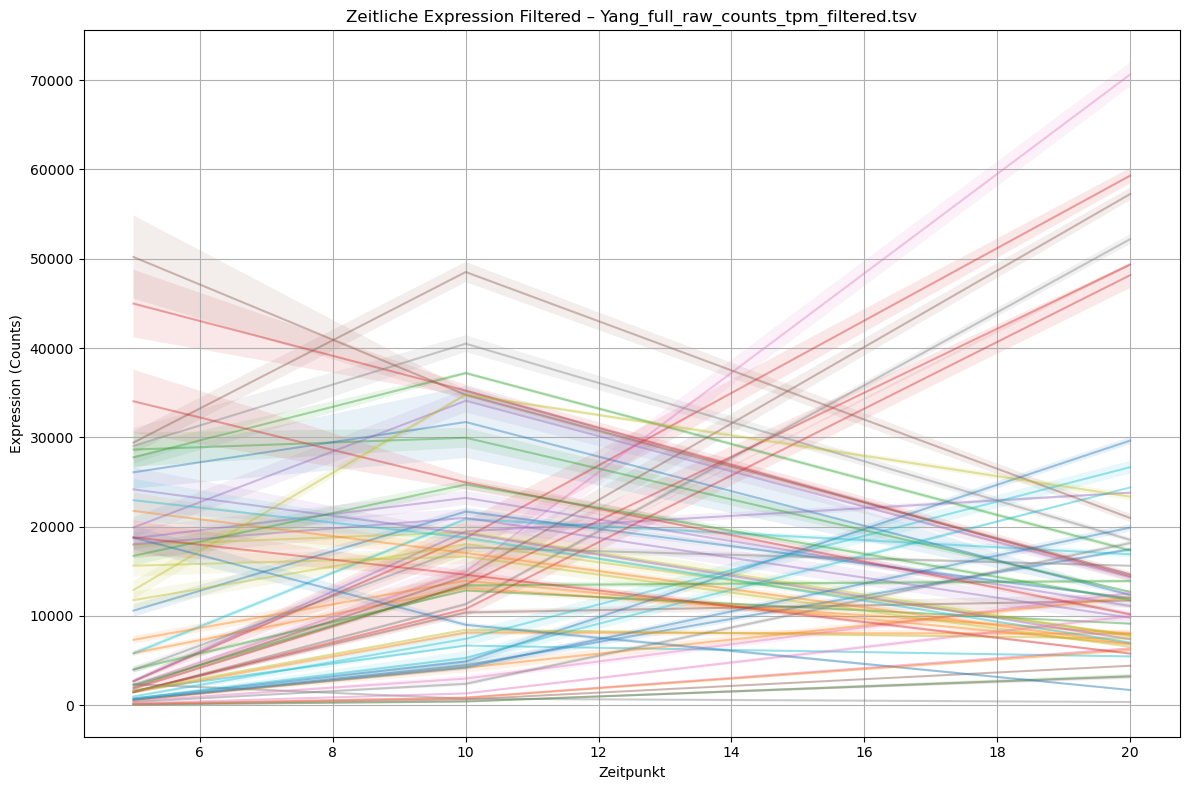

In [2]:
def plot_time_series_comparison(folder_raw, folder_filtered):
    raw_files = list_data_files(folder_raw)
    for raw_file in raw_files:
        filtered_file = raw_file.replace("_raw_counts", "_raw_counts_tpm_filtered")

        df_raw = load_filtered_df(folder_raw, raw_file)
        df_filt = load_filtered_df(folder_filtered, filtered_file, require_entity=False)

        if df_raw is None and df_filt is None:
            continue

        # Hilfsfunktion für Zeitreihenplot
        def plot_time_series(df, title):
            timepoint_cols = [col for col in df.columns if re.match(r"(\d+)_R\d+", col)]
            if not timepoint_cols:
                print(f"Ungültige Zeitpunkt-Spalten in {title}")
                return

            timepoints = sorted({int(re.match(r"(\d+)_R\d+", col).group(1)) for col in timepoint_cols})
            plt.figure(figsize=(12, 8))

            for gene in df.index:
                means, stds = [], []
                for t in timepoints:
                    t_cols = [col for col in timepoint_cols if col.startswith(f"{t}_R")]
                    values = df.loc[gene, t_cols].values
                    means.append(np.mean(values))
                    stds.append(np.std(values))
                plt.plot(timepoints, means, alpha=0.4)
                plt.fill_between(timepoints, np.array(means) - stds, np.array(means) + stds, alpha=0.1)

            plt.xlabel("Zeitpunkt")
            plt.ylabel("Expression (Counts)")
            plt.title(title)
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        if df_raw is not None:
            plot_time_series(df_raw, f"Zeitliche Expression Raw – {raw_file}")
        else:
            print("Raw-Daten unbrauchbar")

        if df_filt is not None:
            plot_time_series(df_filt, f"Zeitliche Expression Filtered – {filtered_file}")
        else:
            print("Filtered-Daten unbrauchbar")

# Aufruf
plot_time_series_comparison(folder_raw, folder_filtered)


### Visualisierung via Heatmaps

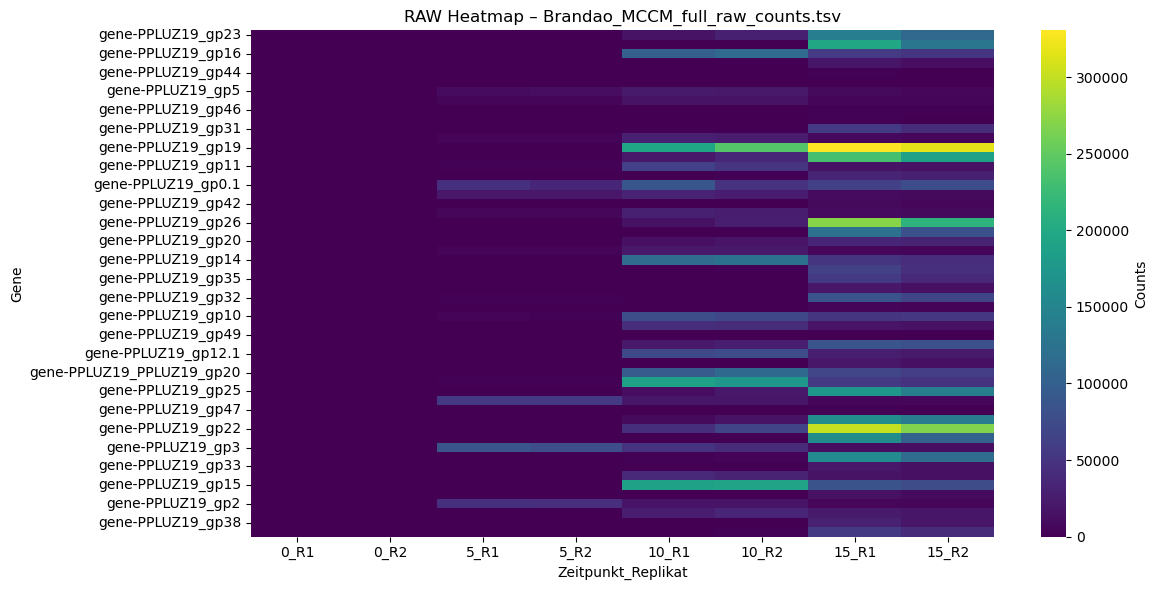

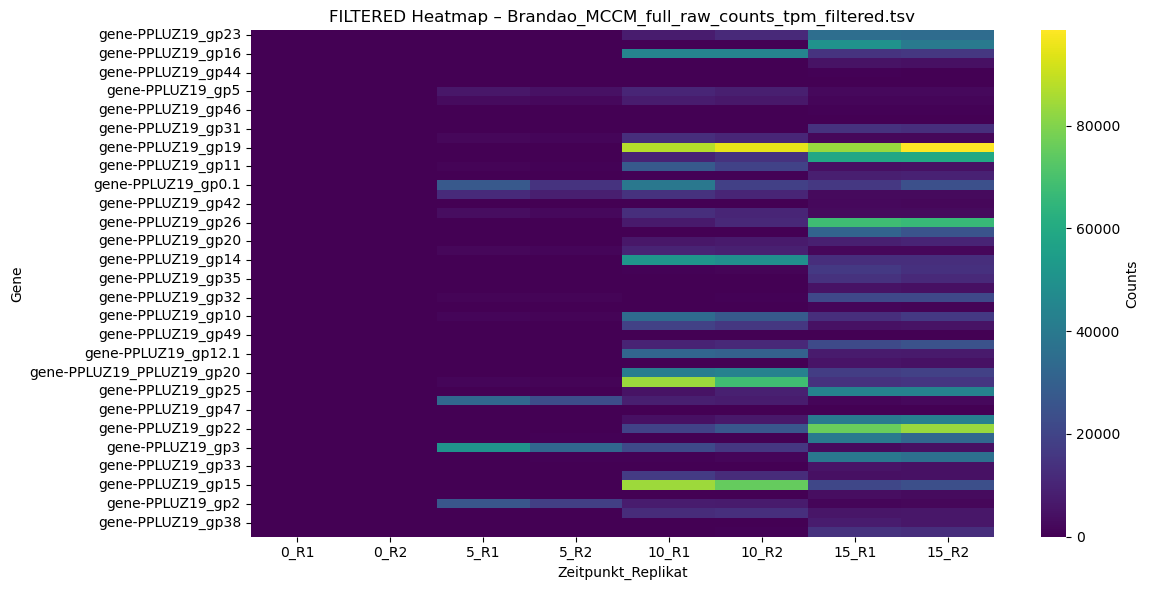

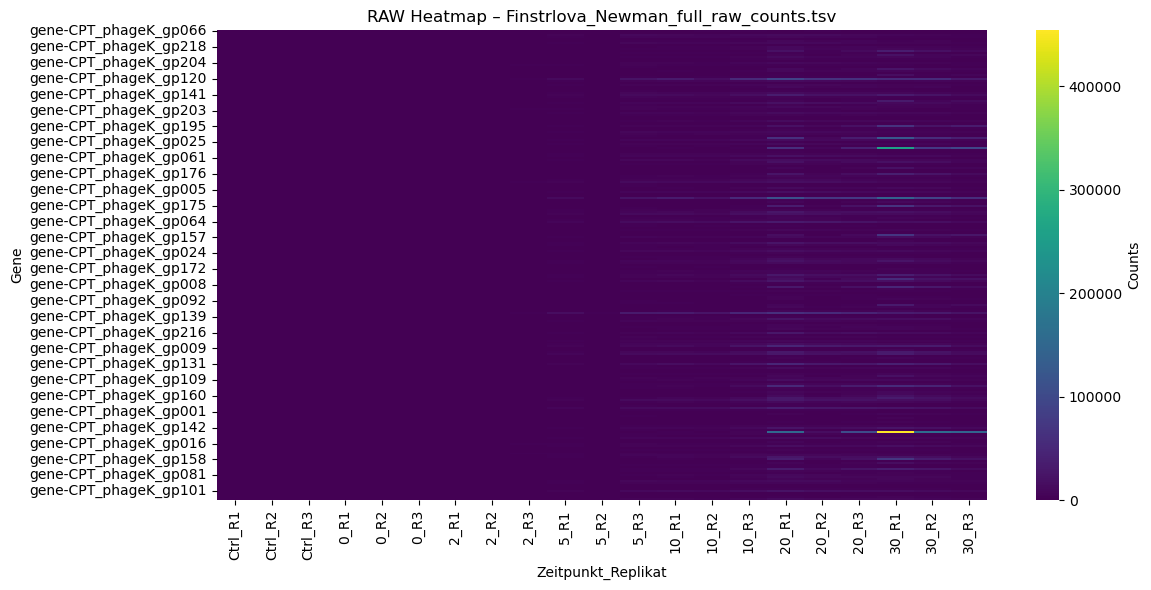

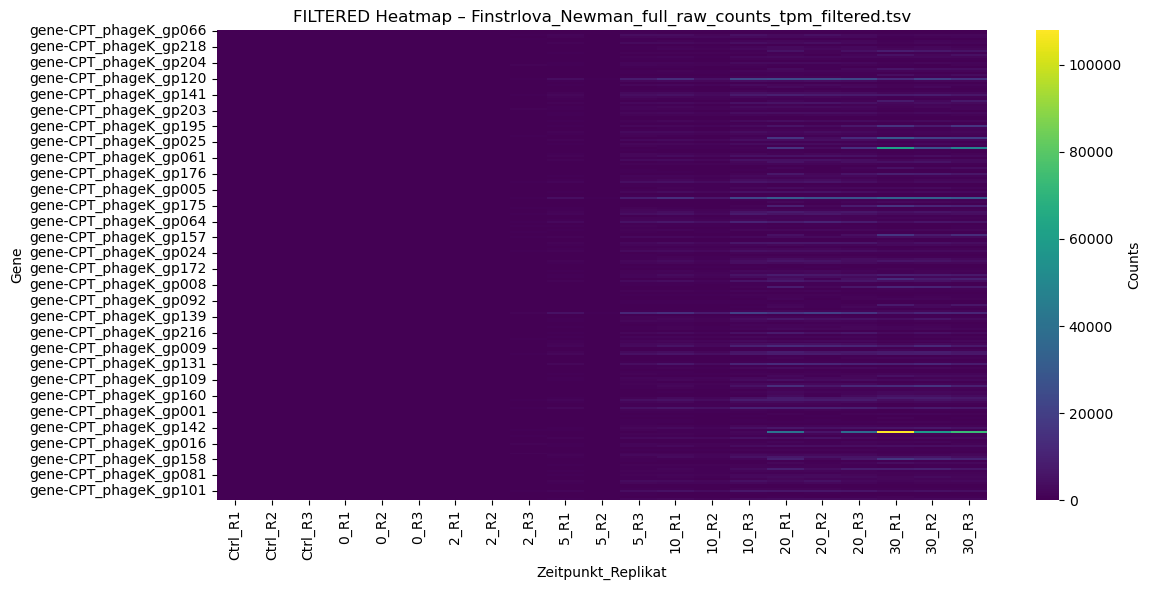

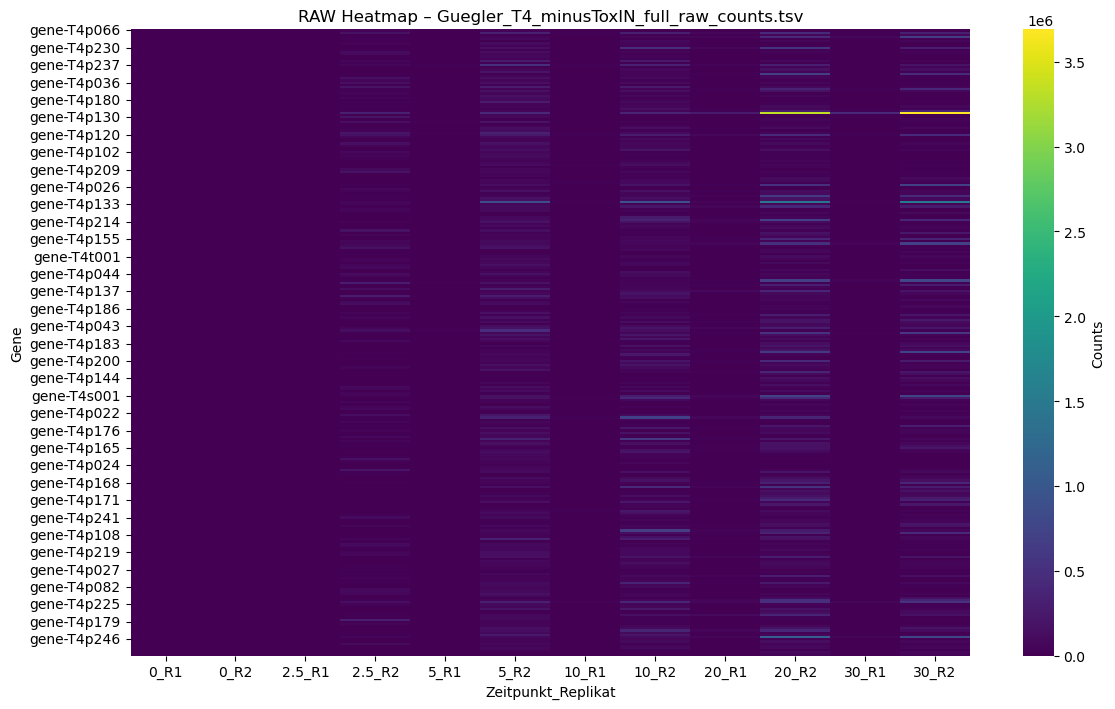

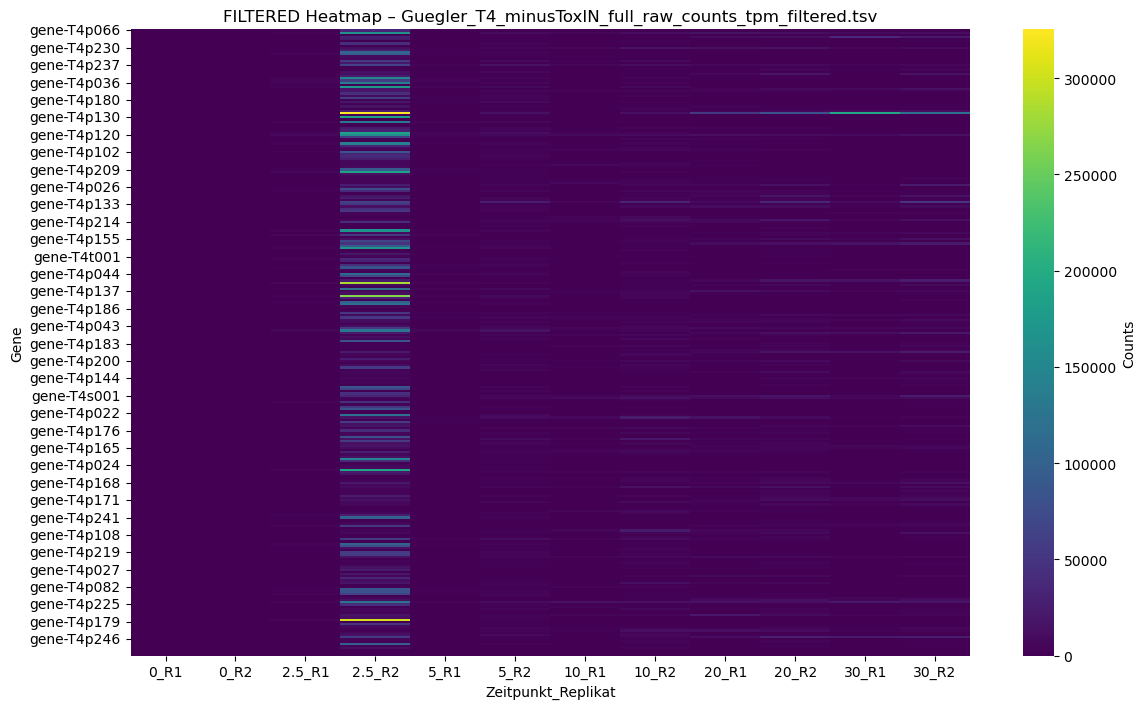

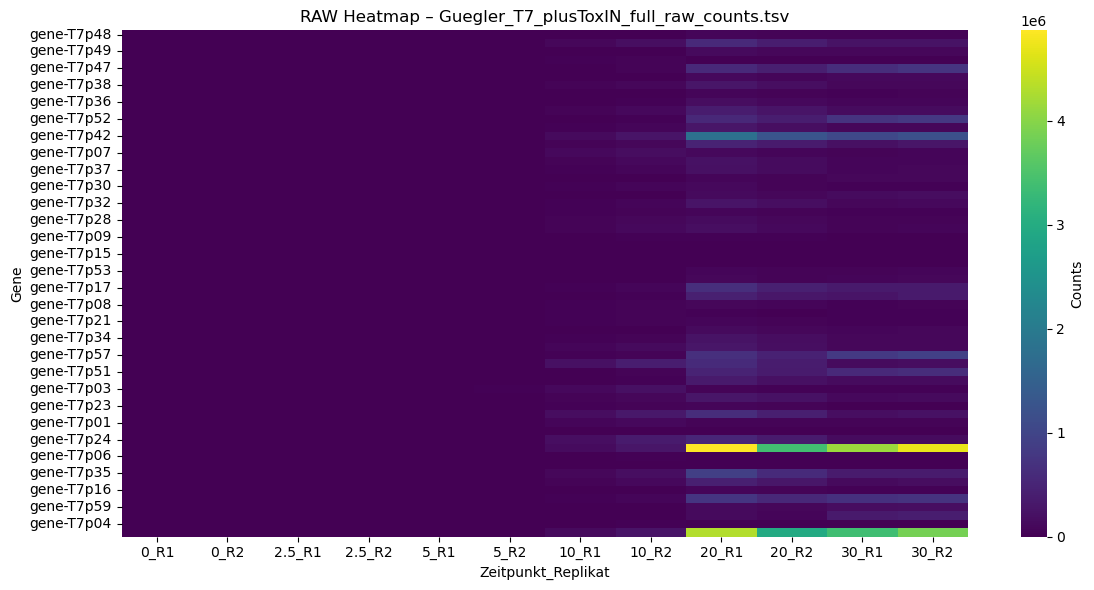

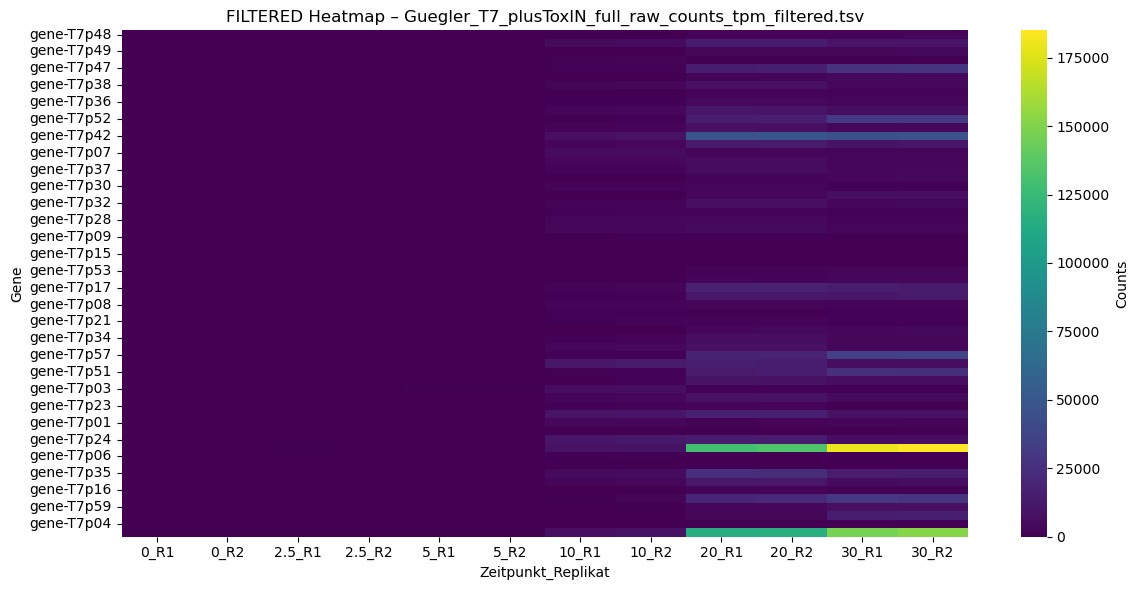

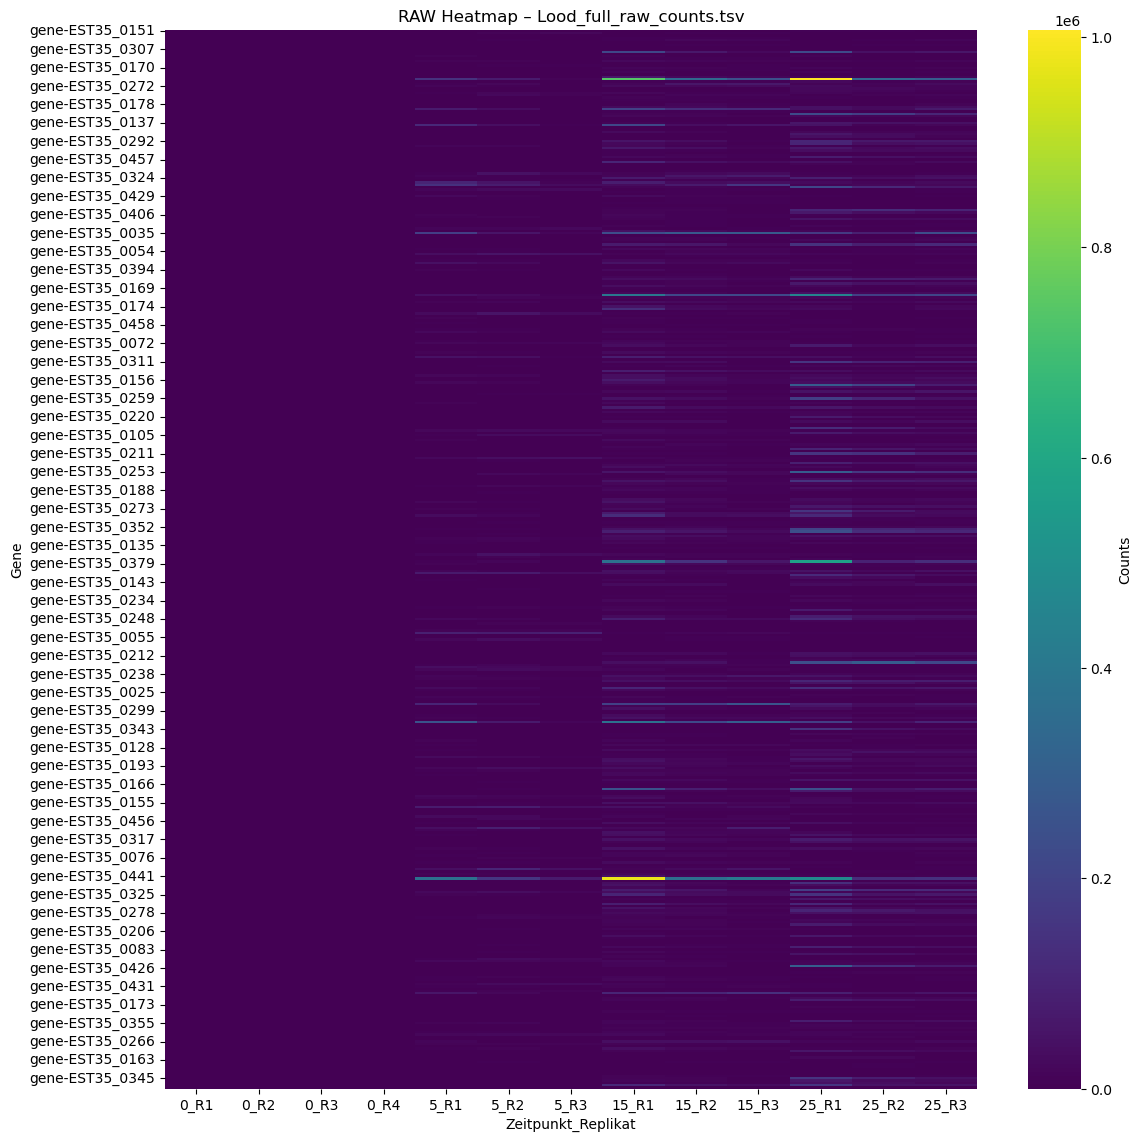

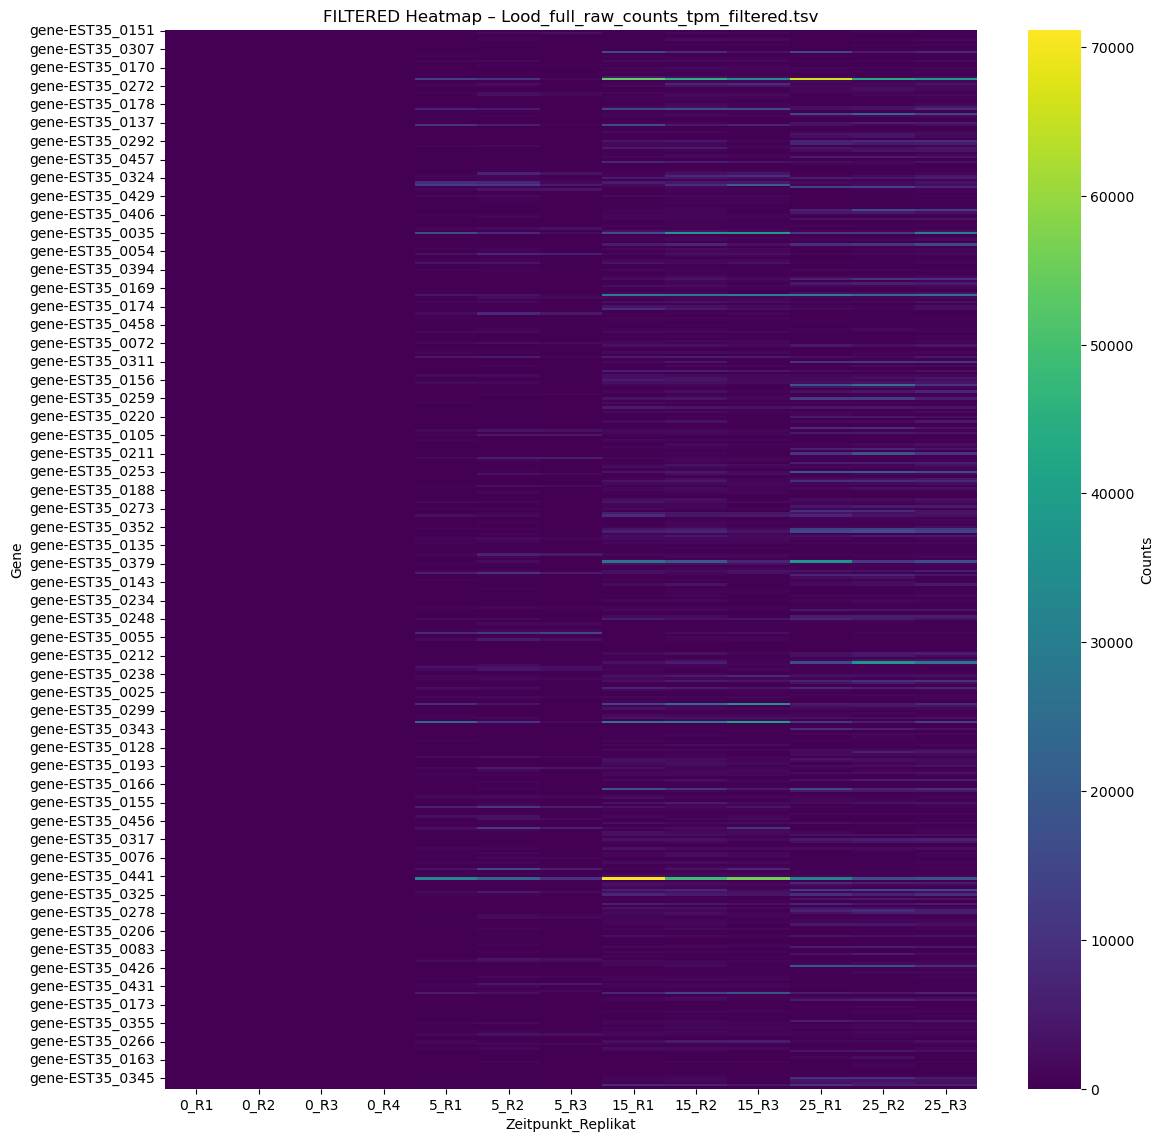

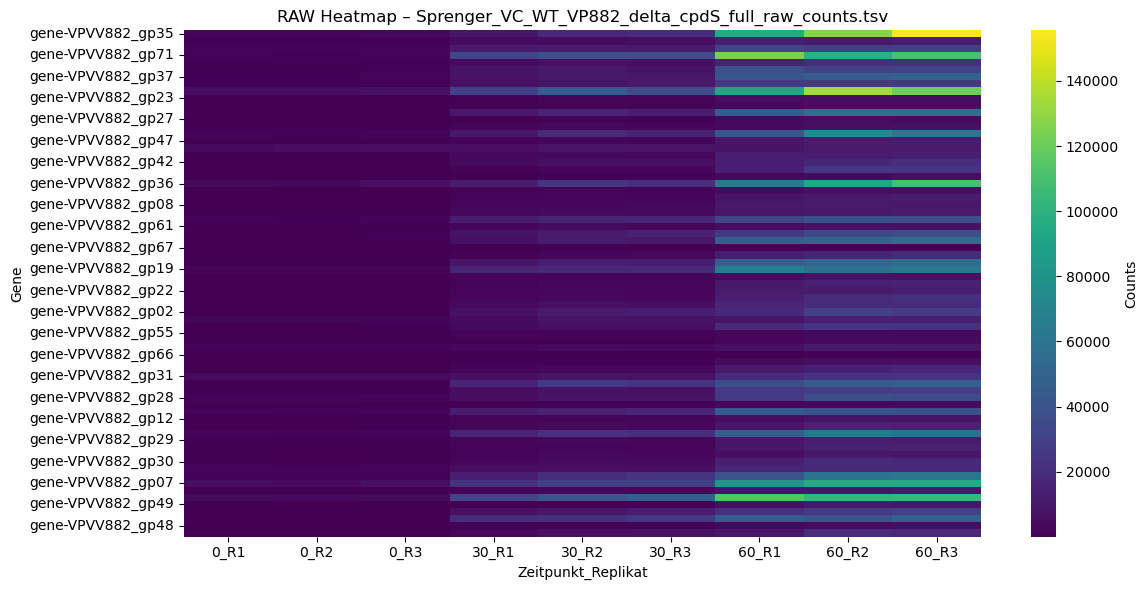

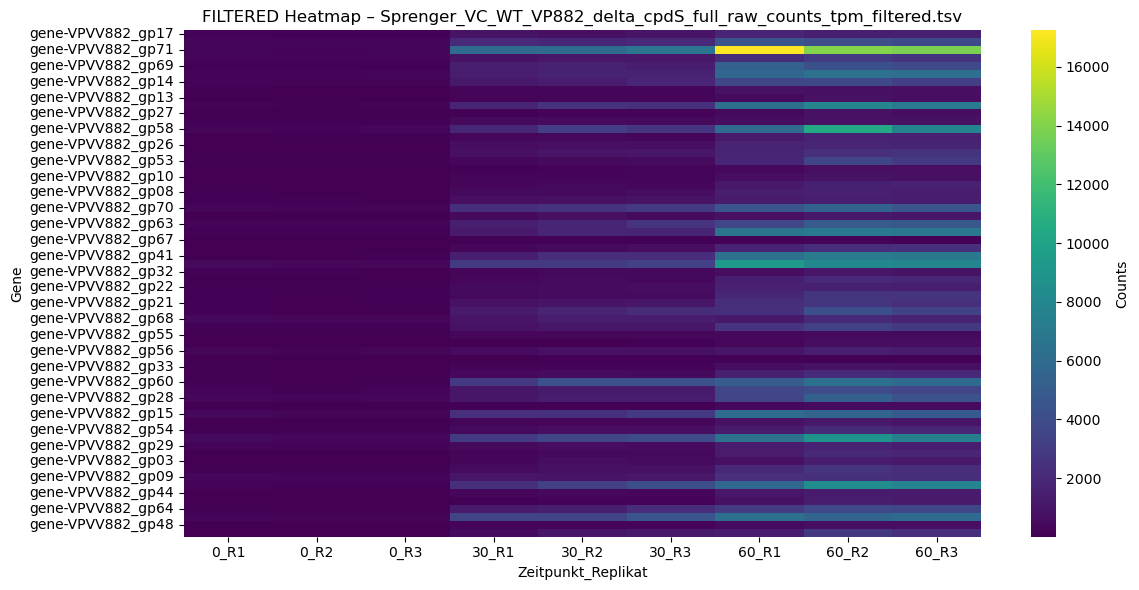

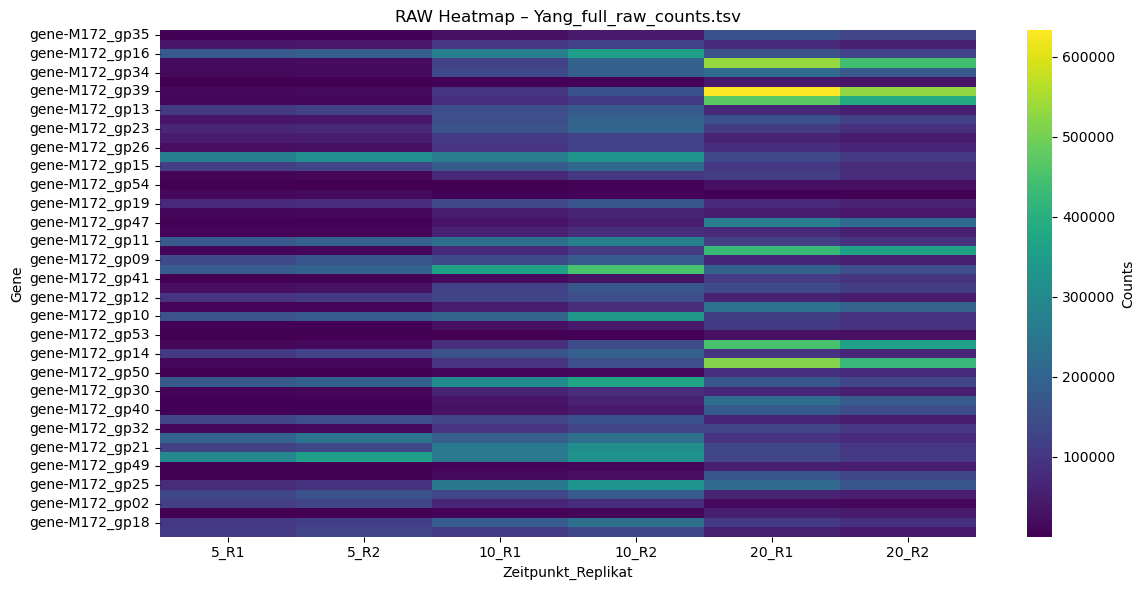

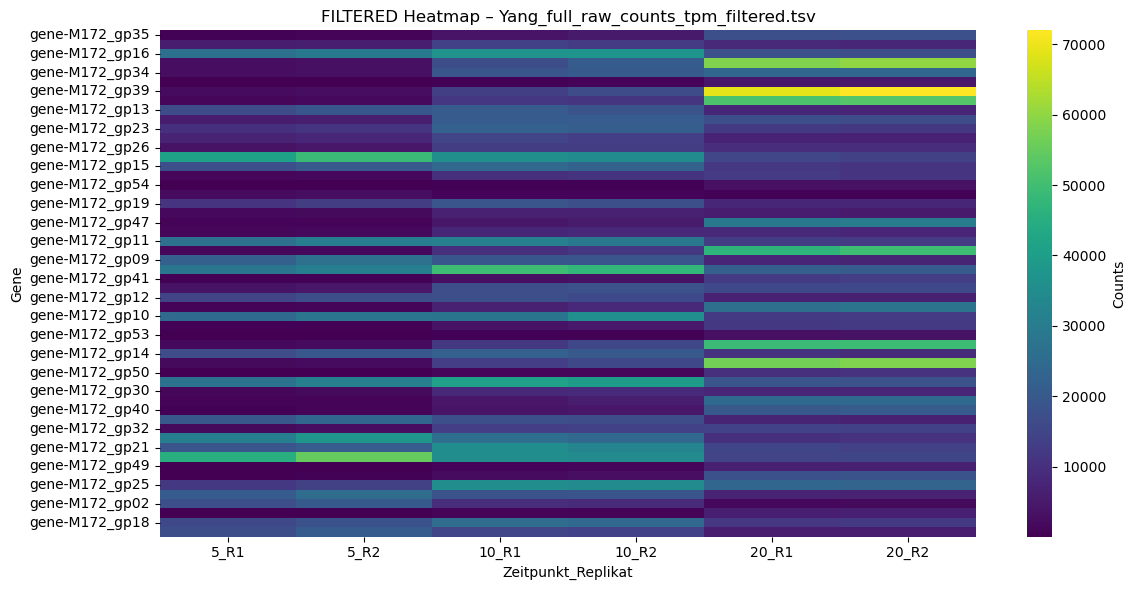

In [3]:
def plot_raw_vs_filtered_heatmaps():
    raw_files = list_data_files(folder_raw)
    for raw_file in raw_files:
        filtered_file = raw_file.replace("_raw_counts", "_raw_counts_tpm_filtered")

        df_raw = load_filtered_df(folder_raw, raw_file)
        df_filt = load_filtered_df(folder_filtered, filtered_file, require_entity=False)

        if df_raw is None and df_filt is None:
            continue

        if df_raw is not None:
            plot_heatmap(df_raw, f"RAW Heatmap – {raw_file}")
        else:
            print("Raw-Daten unbrauchbar")

        if df_filt is not None:
            plot_heatmap(df_filt, f"FILTERED Heatmap – {filtered_file}")
        else:
            print("Filtered-Daten unbrauchbar")

plot_raw_vs_filtered_heatmaps()


### PCA Visualisierung der "raw counts" und der normalisierten "counts" via Z-Score

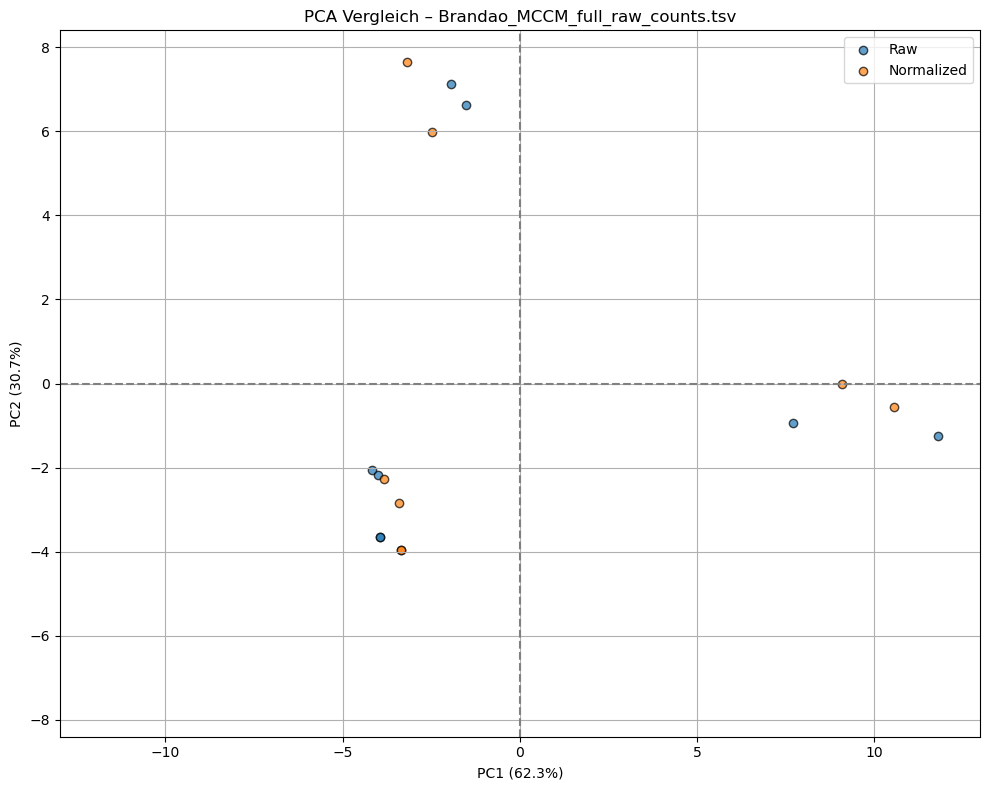

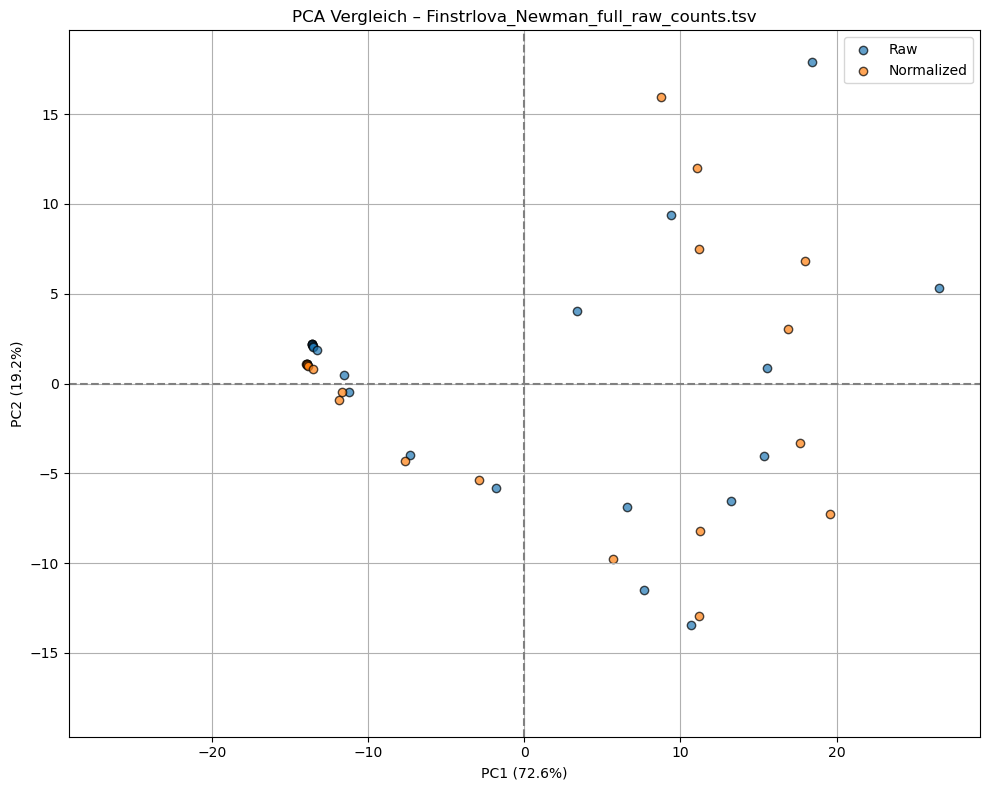

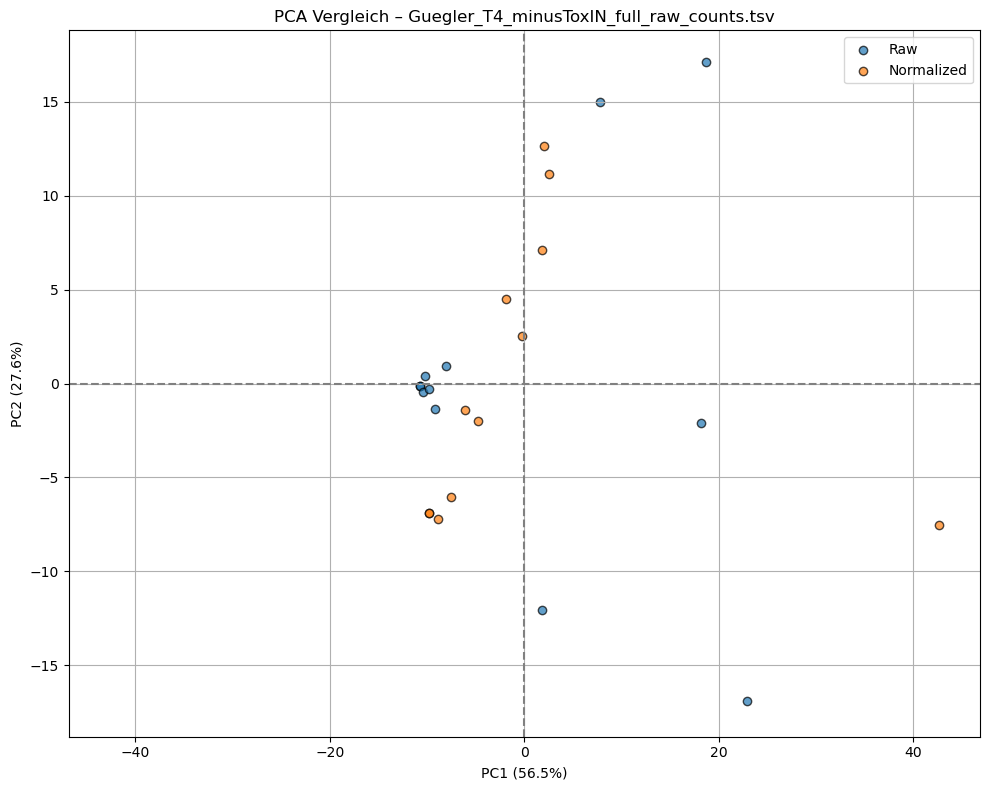

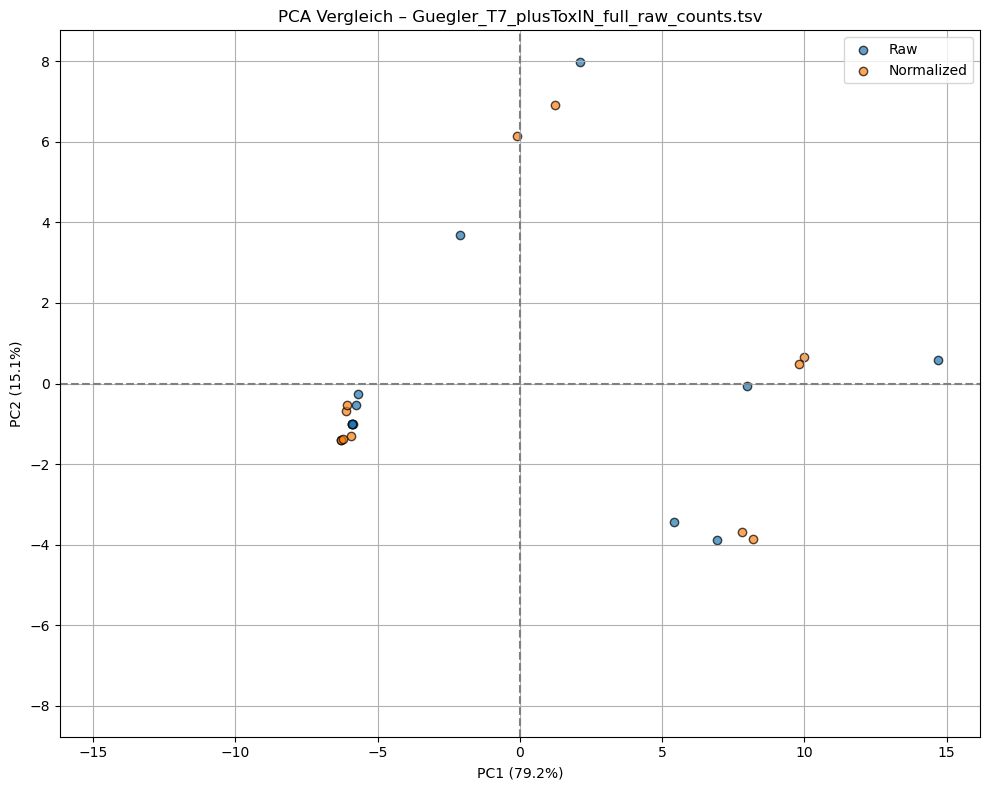

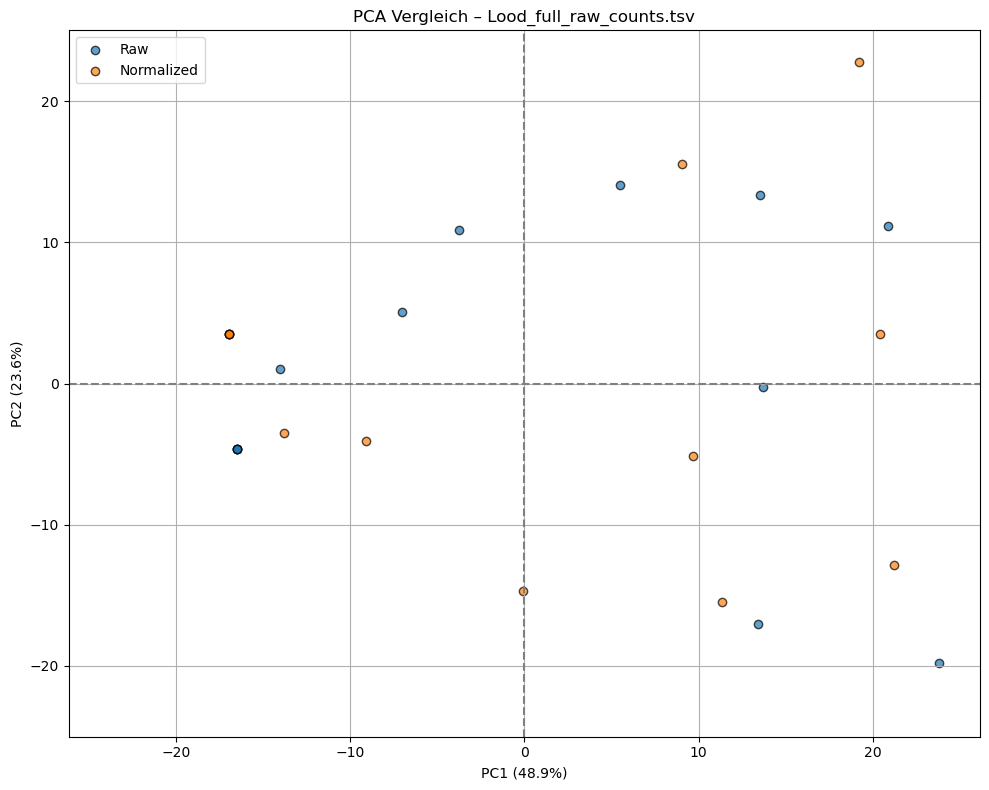

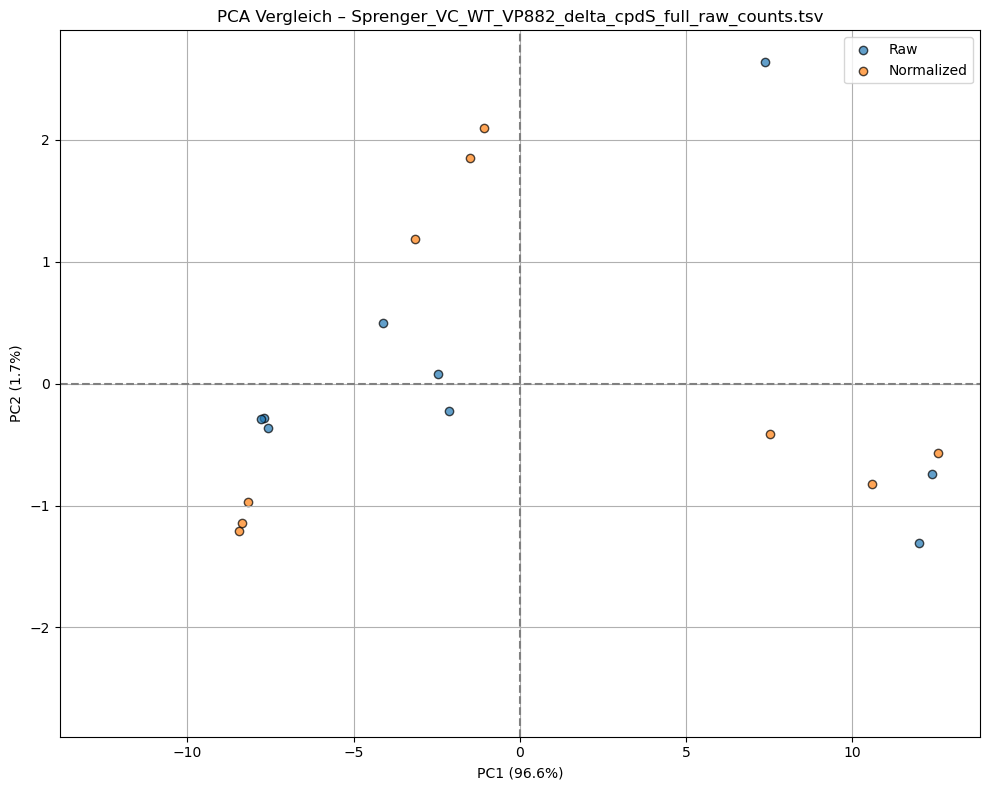

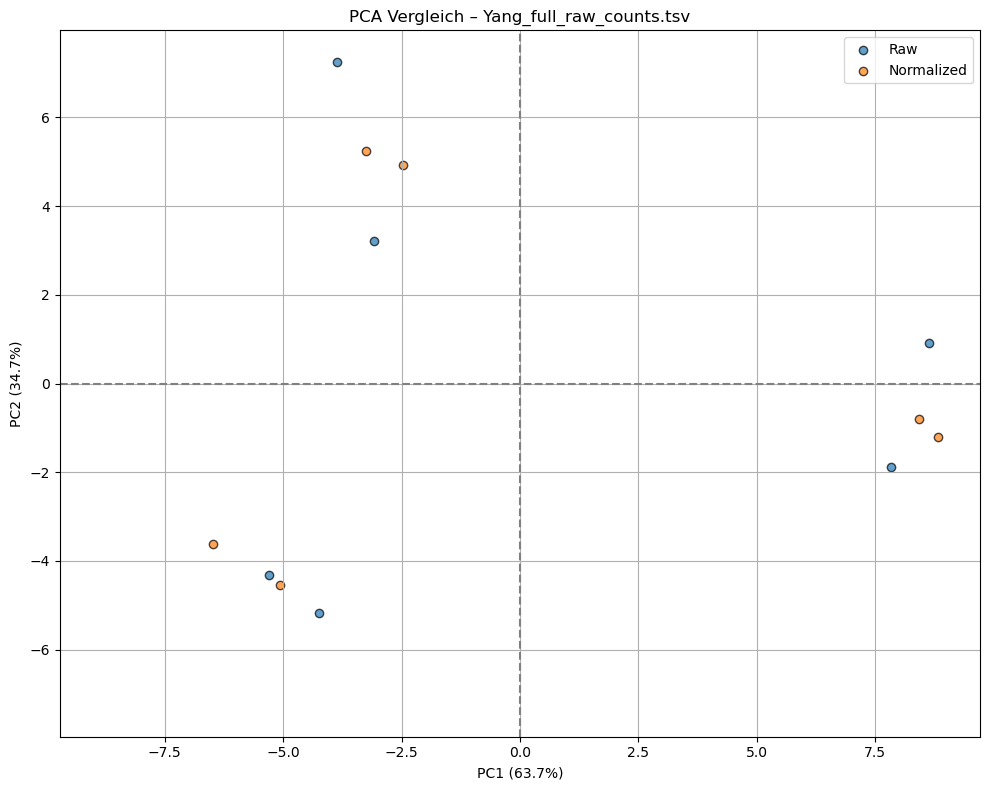

In [ ]:
def run_pca_comparison(folder_raw, folder_norm):
    for datei in list_data_files(folder_raw):
        df_raw = load_filtered_df(folder_raw, datei)
        if df_raw is None:
            continue

        norm_file = datei.replace("_raw_counts", "_raw_counts_tpm_filtered")
        df_norm = load_filtered_df(folder_norm, norm_file)

        if df_norm is not None:
            common_genes = df_raw.index.intersection(df_norm.index)
            common_cols = df_raw.columns.intersection(df_norm.columns)
            df_raw = df_raw.loc[common_genes, common_cols]
            df_norm = df_norm.loc[common_genes, common_cols]

        X_raw = StandardScaler().fit_transform(df_raw.T) # Z-Score
        pca = PCA(n_components=2)
        pcs_raw = pca.fit_transform(X_raw)
        var_raw = pca.explained_variance_ratio_ * 100

        if df_norm is not None:
            X_norm = StandardScaler().fit_transform(df_norm.T)
            pcs_norm = pca.fit_transform(X_norm)
            var_norm = pca.explained_variance_ratio_ * 100

        plt.figure(figsize=(10, 8))
        plt.scatter(pcs_raw[:, 0], pcs_raw[:, 1], label="Raw", alpha=0.7, edgecolor='k')

        if df_norm is not None:
            plt.scatter(pcs_norm[:, 0], pcs_norm[:, 1], label="Normalized", alpha=0.7, edgecolor='k')

        x_lim = max(abs(pcs_raw[:, 0]).max(), abs(pcs_norm[:, 0]).max() if df_norm is not None else 0)
        y_lim = max(abs(pcs_raw[:, 1]).max(), abs(pcs_norm[:, 1]).max() if df_norm is not None else 0)

        plt.xlim(-x_lim * 1.1, x_lim * 1.1)
        plt.ylim(-y_lim * 1.1, y_lim * 1.1)
        plt.axhline(0, color='gray', linestyle='--')
        plt.axvline(0, color='gray', linestyle='--')
        plt.xlabel(f"PC1 ({var_raw[0]:.1f}%)")
        plt.ylabel(f"PC2 ({var_raw[1]:.1f}%)")
        plt.title(f"PCA Vergleich – {datei}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

run_pca_comparison(folder_raw, folder_filtered)


### PCA (Code von Samuel) 

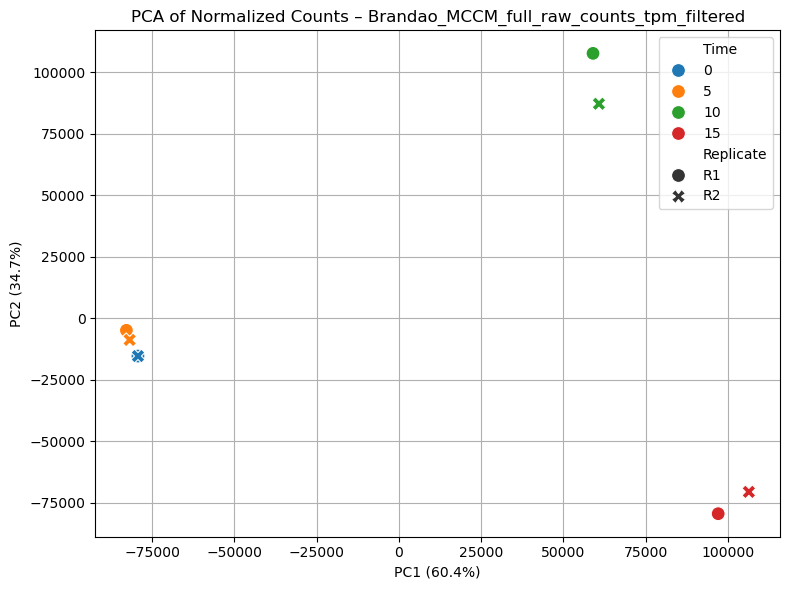

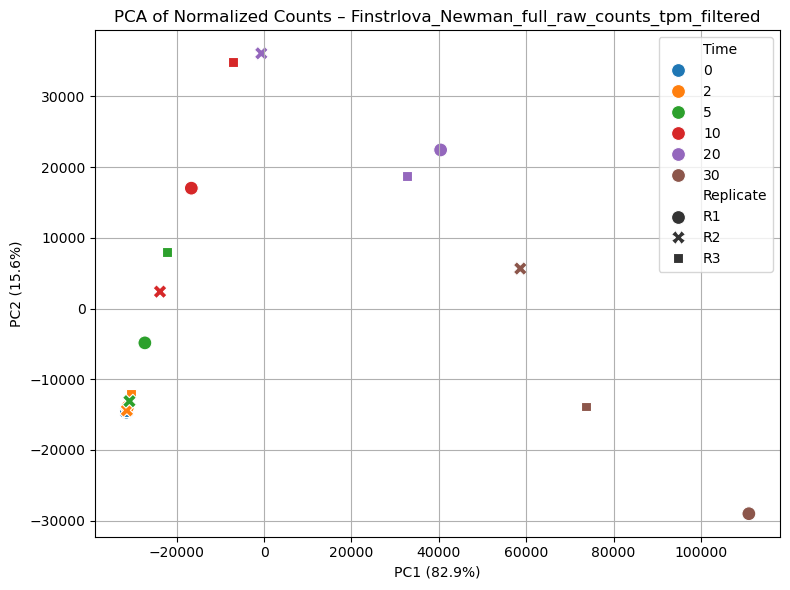

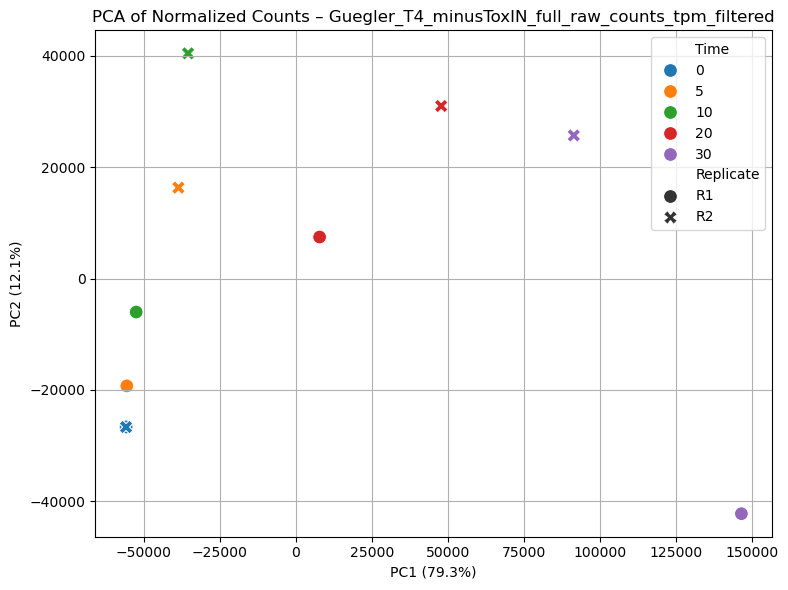

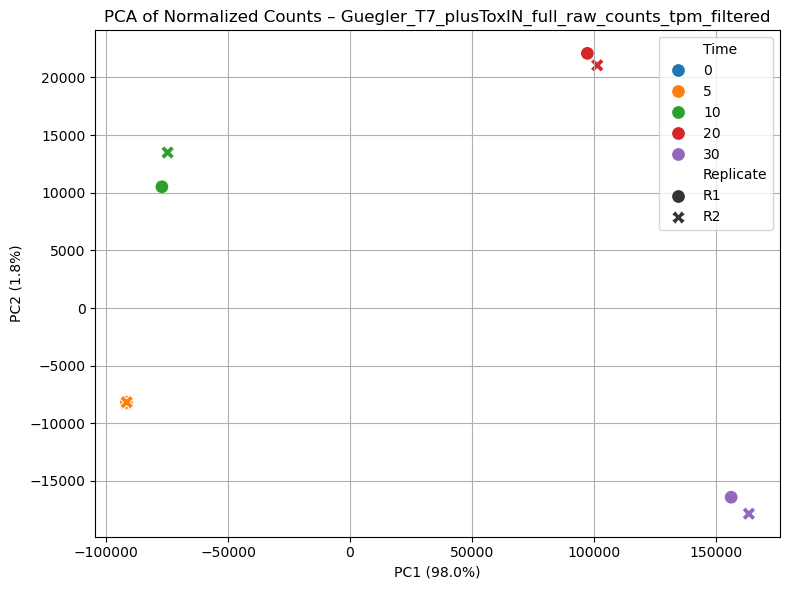

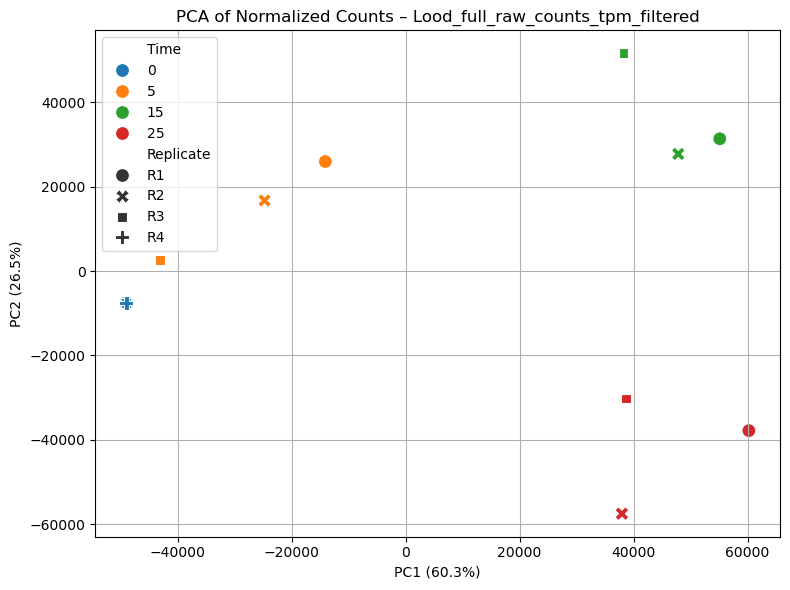

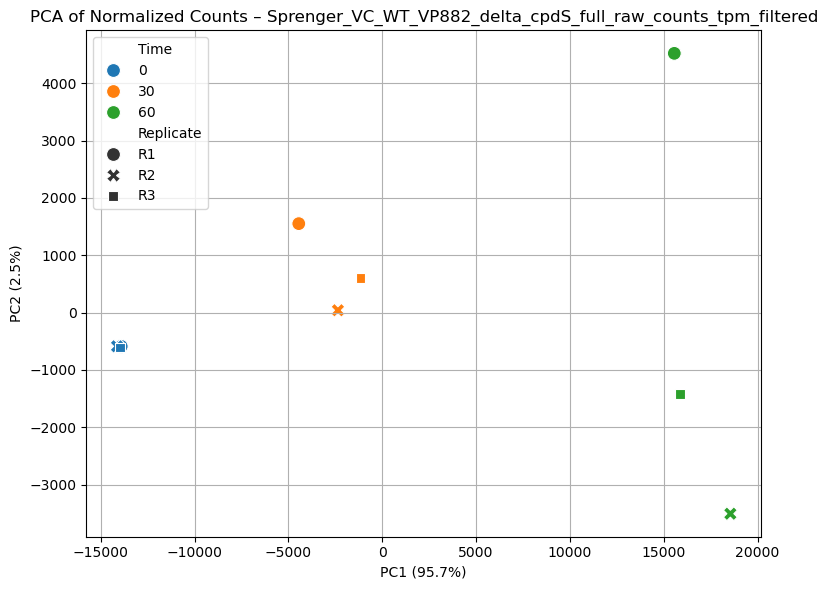

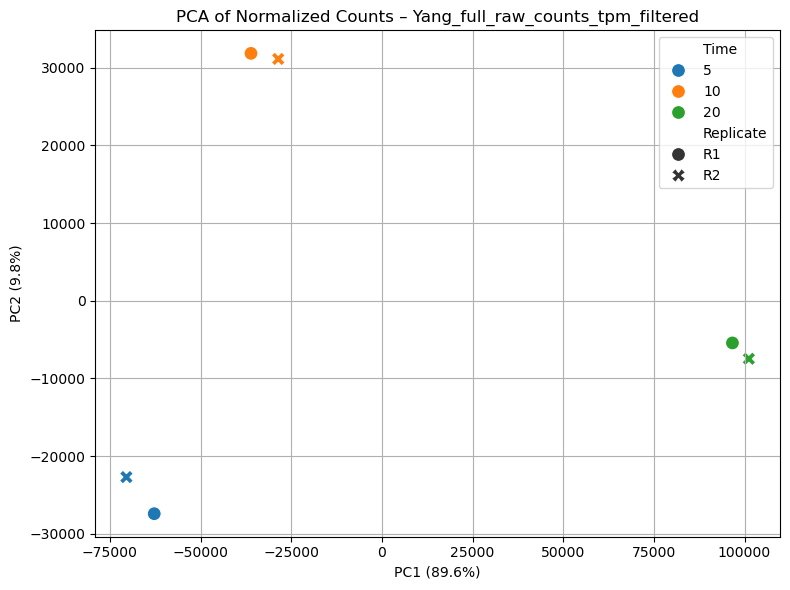

In [5]:
def run_pca_individual(input_folder):
    for ds in Path(input_folder).glob("*.tsv"):
        df = pd.read_csv(ds, sep="\t")
        sample_cols = [col for col in df.columns if re.match(r"^\d+_R\d+$", col)]
        data = df[sample_cols].T
        data.columns = df["Geneid"]
        data.index.name = "Sample"
        data = data.reset_index()
        data["Time"] = data["Sample"].apply(lambda x: x.split("_")[0])
        data["Replicate"] = data["Sample"].apply(lambda x: x.split("_")[1])

        features = data.drop(columns=["Sample", "Time", "Replicate"])
        pca = PCA(n_components=2)
        pcs = pca.fit_transform(features)

        data["PC1"] = pcs[:, 0]
        data["PC2"] = pcs[:, 1]

        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=data, x="PC1", y="PC2", hue="Time", style="Replicate", s=100, palette="tab10")
        plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
        plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
        plt.title(f"PCA of Normalized Counts – {ds.stem}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

run_pca_individual(folder_filtered)

